In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("LOTE_Intern_ML_Dataset_20240531.xlsx", skiprows=5)

In [3]:
data = df.copy()

# Data Cleaning and Preprocessing

In [4]:
data['REGISTERED CURRENT TERM'] = data['REGISTERED CURRENT TERM'].fillna('No')
data = data[(data['APPLIED INTERNATIONAL'] == 0) & 
                     (data['REGISTERED CURRENT TERM'] == 'No')]

In [5]:
print("TOTAL HS LANG YEARS TAKEN:", data['TOTAL HS LANG YEARS TAKEN'].isnull().sum())
print("HS GPA:", data['HS GPA'].isnull().sum())
print("HS AP UNITS:", data['HS AP UNITS'].isnull().sum())

TOTAL HS LANG YEARS TAKEN: 935
HS GPA: 13268
HS AP UNITS: 14243


In [6]:
mode_gender = data['APPLIED GENDER CD'].mode()[0]
data['APPLIED GENDER CD'] = data['APPLIED GENDER CD'].fillna(mode_gender)
data = data[data['APPLIED RACE ETH ONE'] != 'Unknown']

data['FAFSA'] = data.apply(
    lambda row: 1.0 if pd.isnull(row['FAFSA']) and row['APPLIED FEE WAIVER ALL'] == 1 
                else (0.0 if pd.isnull(row['FAFSA']) and row['APPLIED FEE WAIVER ALL'] == 0 else row['FAFSA']),
    axis=1
)

data = data.dropna(subset=['TOTAL HS LANG YEARS TAKEN'])
data['HS GPA'] = data['HS GPA'].fillna(data['HS GPA'].median())
data['HS AP UNITS'] = data['HS AP UNITS'].fillna(data['HS AP UNITS'].median())

# Zip
data['HS ZIP'] = data['HS ZIP'].astype(str)
data['ADDR PERM ZIP'] = data['ADDR PERM ZIP'].astype(str)
data['HS ZIP'] = data['HS ZIP'].apply(lambda x: x[:5] if pd.notnull(x) else x)
data['ADDR PERM ZIP'] = data['ADDR PERM ZIP'].apply(lambda x: x[:5] if pd.notnull(x) else x)
zip_income = pd.read_csv('ACSST5Y2022.S1901-Data.csv', skiprows=[1])
zip_df = zip_income.copy()
zip_df = zip_df[['NAME', 'S1901_C01_012E']]
zip_df = zip_df.rename(columns={'NAME': 'ZIP Code', 'S1901_C01_012E': 'Median Household Income'})
zip_df['ZIP Code'] = zip_df['ZIP Code'].apply(lambda x: x.split()[-1])
zip_df['Median Household Income'] = pd.to_numeric(zip_df['Median Household Income'], errors='coerce')
median_income = zip_df['Median Household Income'].median()
zip_df['Median Household Income'].fillna(median_income, inplace=True)
zip_df['Income Category'] = pd.qcut(zip_df['Median Household Income'], 4, labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High'])
# Merge the income categories for HS ZIP
data = pd.merge(data, zip_df[['ZIP Code', 'Income Category']], left_on='HS ZIP', right_on='ZIP Code', how='left')

# Rename the 'Income Category' column for HS ZIP
data = data.rename(columns={'Income Category': 'HS ZIP Income Level'})

# Drop the extra 'ZIP Code' column added by the merge
data = data.drop(columns=['ZIP Code'])

# Merge the income categories for ADDR PERM ZIP
data = pd.merge(data, zip_df[['ZIP Code', 'Income Category']], left_on='ADDR PERM ZIP', right_on='ZIP Code', how='left')

# Rename the 'Income Category' column for ADDR PERM ZIP
data = data.rename(columns={'Income Category': 'ADDR ZIP Income Level'})

# Drop the extra 'ZIP Code' column added by the merge
data = data.drop(columns=['ZIP Code'])

data['HS ZIP Income Level'] = data.apply(lambda row: row['ADDR ZIP Income Level'] 
                                         if pd.isnull(row['HS ZIP Income Level']) else row['HS ZIP Income Level'], axis=1)
data['ADDR ZIP Income Level'] = data.apply(lambda row: row['HS ZIP Income Level'] 
                                           if pd.isnull(row['ADDR ZIP Income Level']) else row['ADDR ZIP Income Level'], axis=1)

data = data.dropna(subset = ['ADDR ZIP Income Level','HS ZIP Income Level'])

# Encoding
data['DEGREE ACHIEVED'] = data['DEGREE ACHIEVED'].fillna('NotAwarded')
data['DEGREE ACHIEVED'] = data['DEGREE ACHIEVED'].apply(lambda x: 1 if x == 'Awarded' else 0)

gender_encoded = pd.get_dummies(data['APPLIED GENDER CD'], prefix = 'Gender')
gender_encoded = gender_encoded.astype(int)
data = pd.concat([data, gender_encoded], axis=1)

race_encoded = pd.get_dummies(data['APPLIED RACE ETH ONE'], prefix = 'Race')
race_encoded = race_encoded.astype(int)
data = pd.concat([data, race_encoded], axis=1)
income_level_mapping = {
    'Low': 0,
    'Lower-Middle': 1,
    'Upper-Middle': 2,
    'High': 3
}
data['HS ZIP Income Level Encoded'] = data['HS ZIP Income Level'].map(income_level_mapping)
data['ADDR ZIP Income Level Encoded'] = data['ADDR ZIP Income Level'].map(income_level_mapping)

In [7]:
# New variables
variables = [
    'APPLIED ATHLETE', # 0 or 1
    'PRIMARY LANGUAGE CD',
    'APPLIED VETERAN', # 0 or 1
    'PARENT 1 EDU LVL',
    'PARENT 2 EDU LVL',
    'AGE'
]

# Check data types and null values
for var in variables:
    print(f"Variable: {var}")
    print(f"Data Type: {data[var].dtype}")
    print(f"Number of Null Values: {data[var].isnull().sum()}\n")

Variable: APPLIED ATHLETE
Data Type: int64
Number of Null Values: 0

Variable: PRIMARY LANGUAGE CD
Data Type: object
Number of Null Values: 9044

Variable: APPLIED VETERAN
Data Type: int64
Number of Null Values: 0

Variable: PARENT 1 EDU LVL
Data Type: object
Number of Null Values: 29761

Variable: PARENT 2 EDU LVL
Data Type: object
Number of Null Values: 29830

Variable: AGE
Data Type: float64
Number of Null Values: 474



In [8]:
# Null values & encoding
data['PRIMARY LANGUAGE CD'] = data['PRIMARY LANGUAGE CD'].fillna('Unknown')
# New column: if the primary langauge is English then 1, else 0
data['PRIMARY LANGUAGE ENGLISH'] = data['PRIMARY LANGUAGE CD'].apply(lambda x: 1 if x == 'E' else 0)
data['AGE'] = data['AGE'].fillna(data['AGE'].median())

For the rows where 'Applied FIRST GENERATION' = 1, the parents did not receive a college education, so I fill in the null values or "No answer" with the most common education LVL below Bachelors Degree. On the other hand, for the rows where 'Applied FIRST GENERATION' = 0, the parents have received a college education at least, I fill in the null values and "No answer" with "Bachelors Degree".

In [9]:
# Deal with PARENT EDU LVL
data['PARENT 1 EDU LVL'] = data['PARENT 1 EDU LVL'].replace("No Answer", None)
data['PARENT 2 EDU LVL'] = data['PARENT 2 EDU LVL'].replace("No Answer", None)

below_bachelors = [
    "Has No High School Diploma",
    "Has High School Diploma",
    "Attended College, No Degree",
    "Associates Degree"
]
common_below_bachelors = data[data['PARENT 1 EDU LVL'].isin(below_bachelors)]['PARENT 1 EDU LVL'].mode()[0]

data.loc[
    (data['APPLIED FIRST GENERATION'] == 1) &
    (data['PARENT 1 EDU LVL'].isnull()),
    'PARENT 1 EDU LVL'
] = common_below_bachelors

data.loc[
    (data['APPLIED FIRST GENERATION'] == 1) &
    (data['PARENT 2 EDU LVL'].isnull()),
    'PARENT 2 EDU LVL'
] = common_below_bachelors

data.loc[
    (data['APPLIED FIRST GENERATION'] == 0) &
    (data['PARENT 1 EDU LVL'].isnull()),
    'PARENT 1 EDU LVL'
] = "Bachelors Degree"

data.loc[
    (data['APPLIED FIRST GENERATION'] == 0) &
    (data['PARENT 2 EDU LVL'].isnull()),
    'PARENT 2 EDU LVL'
] = "Bachelors Degree"

In [10]:
# Econding for PARENT LVL
education_mapping = {
    "Has No High School Diploma": 0,
    "Has High School Diploma": 1,
    "Attended College, No Degree": 2,
    "Associates Degree": 3,
    "Bachelors Degree": 4,
    "Masters Degree": 5,
    "Professional Degree": 6,
    "Doctorate Degree": 7
}

data['PARENT 1 EDU LVL ENCODED'] = data['PARENT 1 EDU LVL'].map(education_mapping)
data['PARENT 2 EDU LVL ENCODED'] = data['PARENT 2 EDU LVL'].map(education_mapping)

In [11]:
key_columns = [
    'APPLIED FIRST GENERATION',
    'Race_Asian', 
    'Race_White',
    'Race_African American or Black', 
    'Race_American-Indian', 
    'Race_Hispanic or Latino',
    'Race_NHPI', 
    'APPLIED URM',
 
    'Gender_F',
    'Gender_M',
 
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',
 
    'HS ZIP Income Level Encoded', 
    'ADDR ZIP Income Level Encoded',
    'APPLIED FEE WAIVER ALL',
    'FAFSA',
 
    'APPLIED ATHLETE',
    'PRIMARY LANGUAGE ENGLISH',
    'APPLIED VETERAN',
    'PARENT 1 EDU LVL ENCODED',
    'PARENT 2 EDU LVL ENCODED',
    'AGE'
]

print(data[key_columns].isna().sum())
print(f"Data shape: {data.shape}")

APPLIED FIRST GENERATION          0
Race_Asian                        0
Race_White                        0
Race_African American or Black    0
Race_American-Indian              0
Race_Hispanic or Latino           0
Race_NHPI                         0
APPLIED URM                       0
Gender_F                          0
Gender_M                          0
TOTAL HS LANG YEARS TAKEN         0
HS GPA                            0
HS AP UNITS                       0
HS ZIP Income Level Encoded       0
ADDR ZIP Income Level Encoded     0
APPLIED FEE WAIVER ALL            0
FAFSA                             0
APPLIED ATHLETE                   0
PRIMARY LANGUAGE ENGLISH          0
APPLIED VETERAN                   0
PARENT 1 EDU LVL ENCODED          0
PARENT 2 EDU LVL ENCODED          0
AGE                               0
dtype: int64
Data shape: (55147, 276)


# EDA

## Highschool performance variables

HS GPA Summary Statistics:
count    55147.000000
mean         3.541100
std          0.299779
min          1.440000
25%          3.380000
50%          3.560000
75%          3.750000
max          4.000000
Name: HS GPA, dtype: float64
Missing values in HS GPA: 0 (0.00% of the data)


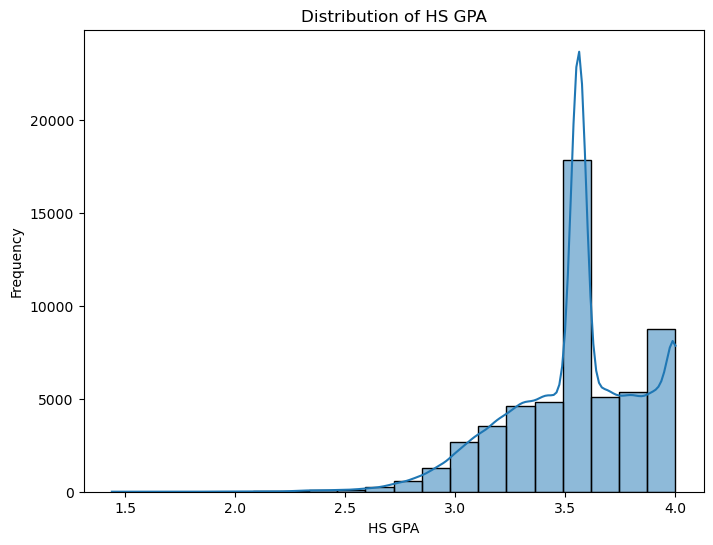

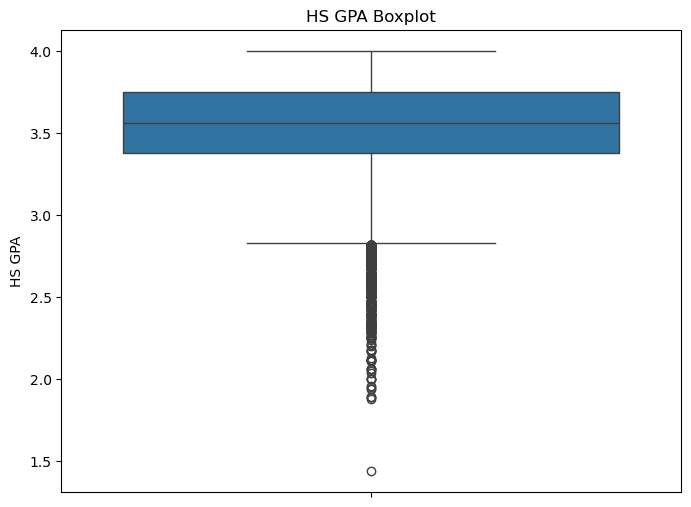

In [12]:
# HS GPA Analysis
print("HS GPA Summary Statistics:")
print(data['HS GPA'].describe())

# Check missing values for HS GPA
missing_hs_gpa = data['HS GPA'].isna().sum()
total = len(data)
print(f"Missing values in HS GPA: {missing_hs_gpa} ({(missing_hs_gpa/total)*100:.2f}% of the data)")

# Plotting HS GPA distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['HS GPA'], bins=20, kde=True)
plt.title('Distribution of HS GPA')
plt.xlabel('HS GPA')
plt.ylabel('Frequency')
plt.show()

# Boxplot for identifying outliers in HS GPA
plt.figure(figsize=(8, 6))
sns.boxplot(data['HS GPA'])
plt.title('HS GPA Boxplot')
plt.show()

Total HS Lang Years Summary Statistics:
count    55147.000000
mean         3.503926
std          0.972320
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max         11.000000
Name: TOTAL HS LANG YEARS TAKEN, dtype: float64
Missing values in TOTAL HS LANG YEARS TAKEN: 0 (0.00% of the data)


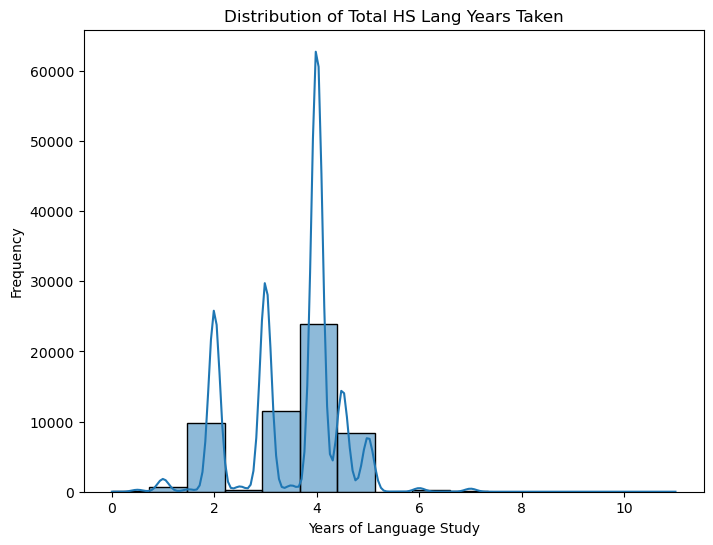

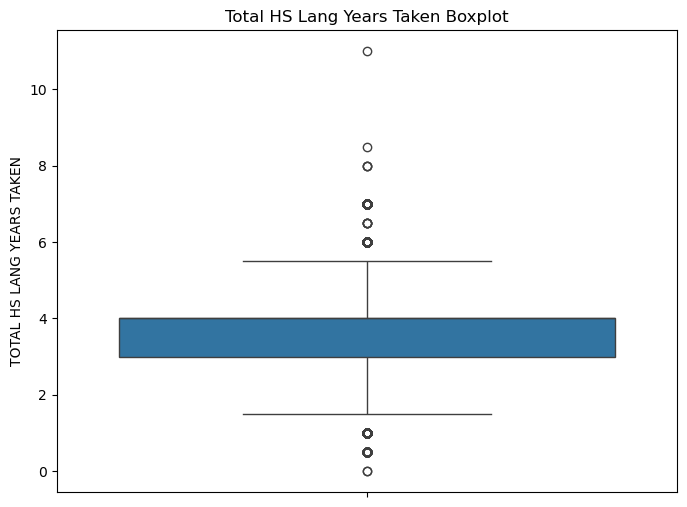

In [13]:
# Total HS Lang Years Analysis
print("Total HS Lang Years Summary Statistics:")
print(data['TOTAL HS LANG YEARS TAKEN'].describe())

# Check missing values
missing_lang_years = data['TOTAL HS LANG YEARS TAKEN'].isna().sum()
print(f"Missing values in TOTAL HS LANG YEARS TAKEN: {missing_lang_years} ({(missing_lang_years/total)*100:.2f}% of the data)")

# Plotting the distribution of Total HS Lang Years Taken
plt.figure(figsize=(8, 6))
sns.histplot(data['TOTAL HS LANG YEARS TAKEN'], bins=15, kde=True)
plt.title('Distribution of Total HS Lang Years Taken')
plt.xlabel('Years of Language Study')
plt.ylabel('Frequency')
plt.show()

# Boxplot for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data['TOTAL HS LANG YEARS TAKEN'])
plt.title('Total HS Lang Years Taken Boxplot')
plt.show()


HS AP Units Summary Statistics:
count    55147.000000
mean         5.473548
std          2.810657
min          0.250000
25%          4.000000
50%          5.000000
75%          7.000000
max         28.000000
Name: HS AP UNITS, dtype: float64
Missing values in HS AP UNITS: 0 (0.00% of the data)


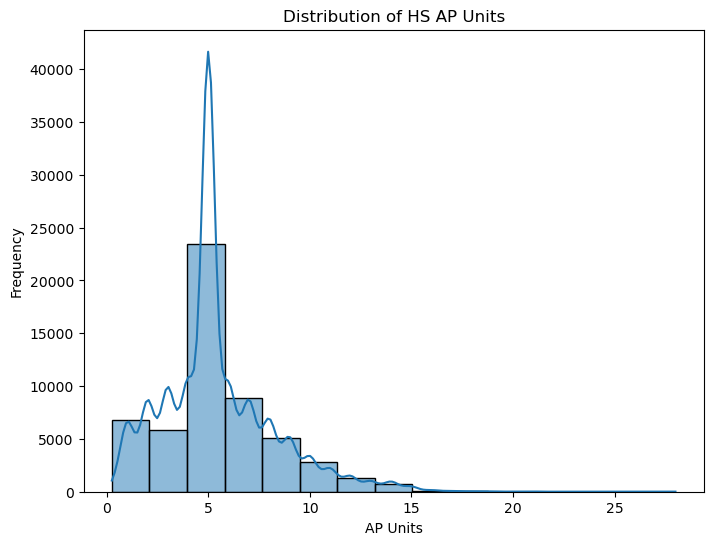

In [14]:
# HS AP Units Analysis
print("HS AP Units Summary Statistics:")
print(data['HS AP UNITS'].describe())

# Check missing values for HS AP UNITS
missing_ap_units = data['HS AP UNITS'].isna().sum()
print(f"Missing values in HS AP UNITS: {missing_ap_units} ({(missing_ap_units/total)*100:.2f}% of the data)")

# Plotting the distribution of HS AP Units
plt.figure(figsize=(8, 6))
sns.histplot(data['HS AP UNITS'], bins=15, kde=True)
plt.title('Distribution of HS AP Units')
plt.xlabel('AP Units')
plt.ylabel('Frequency')
plt.show()


## Parental Background

First Generation Status Distribution:
APPLIED FIRST GENERATION
0    41430
1    13717
Name: count, dtype: int64
Missing values in APPLIED FIRST GENERATION: 0 (0.00% of the data)


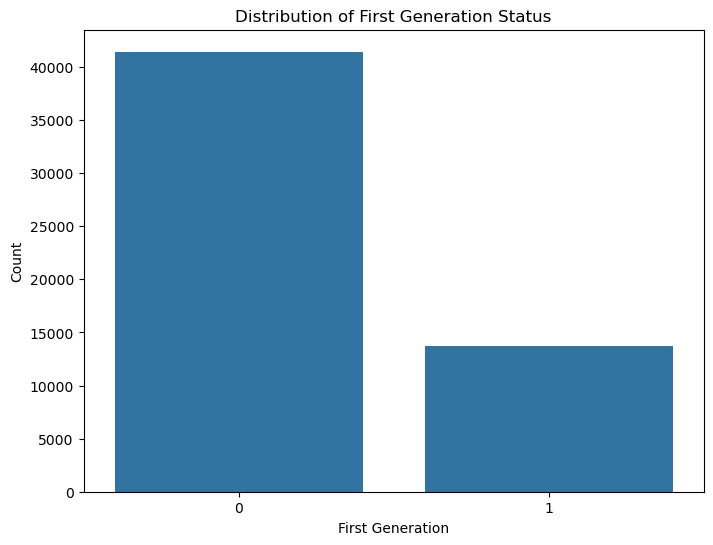

In [15]:
# First Generation Status
print("First Generation Status Distribution:")
print(data['APPLIED FIRST GENERATION'].value_counts())

# Check missing values
missing_first_gen = data['APPLIED FIRST GENERATION'].isna().sum()
print(f"Missing values in APPLIED FIRST GENERATION: {missing_first_gen} ({(missing_first_gen/total)*100:.2f}% of the data)")

# Plotting the distribution of First Generation Status
plt.figure(figsize=(8, 6))
sns.countplot(x='APPLIED FIRST GENERATION', data=data)
plt.title('Distribution of First Generation Status')
plt.xlabel('First Generation')
plt.ylabel('Count')
plt.show()


## Demographics

Gender Distribution:
APPLIED GENDER CD
M    28913
F    26206
N       28
Name: count, dtype: int64
Missing values in Gender: 0 (0.00% of the data)


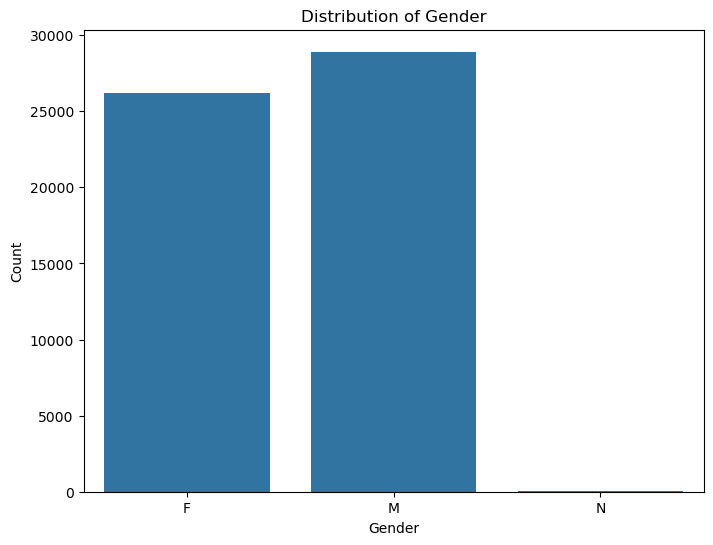

In [16]:
# Gender Distribution
print("Gender Distribution:")
print(data['APPLIED GENDER CD'].value_counts())

missing_gender = data["APPLIED GENDER CD"].isna().sum()
print(f"Missing values in Gender: {missing_gender} ({(missing_gender/total)*100:.2f}% of the data)")

# Plotting the gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='APPLIED GENDER CD', data=data)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


Race/Ethnicity Distribution:
APPLIED RACE ETH ONE
White                        29945
Asian                        11311
Hispanic or Latino            7907
African American or Black     3884
Multi-Race                    2005
NHPI                            58
American-Indian                 37
Name: count, dtype: int64
Missing values in Race: 0 (0.00% of the data)


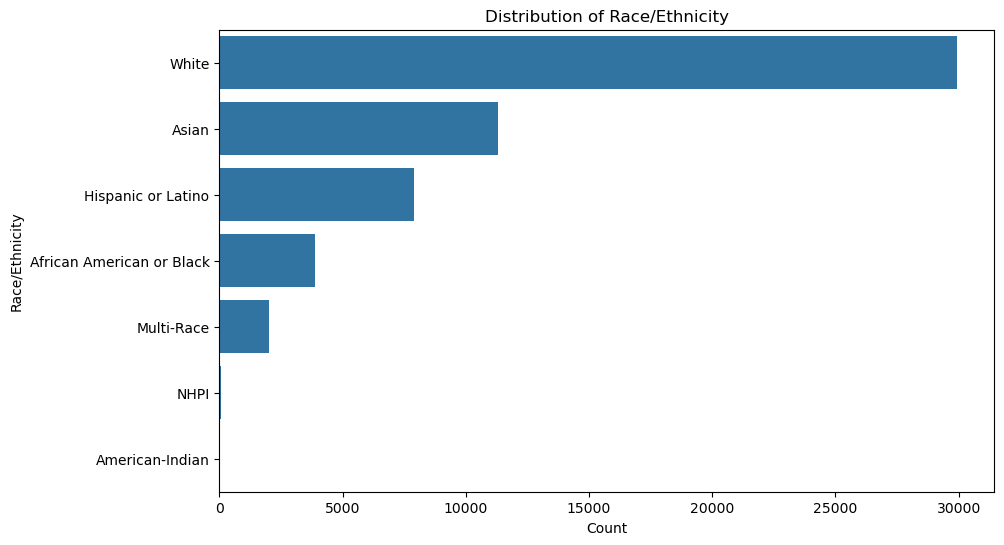

In [17]:
# Race/Ethnicity Distribution
print("Race/Ethnicity Distribution:")
print(data['APPLIED RACE ETH ONE'].value_counts())

missing_race = data['APPLIED RACE ETH ONE'].isna().sum()
print(f"Missing values in Race: {missing_race} ({(missing_race/total)*100:.2f}% of the data)")

# Plotting the race/ethnicity distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='APPLIED RACE ETH ONE', data=data, order=data['APPLIED RACE ETH ONE'].value_counts().index)
plt.title('Distribution of Race/Ethnicity')
plt.xlabel('Count')
plt.ylabel('Race/Ethnicity')
plt.show()


URM Status Distribution:
APPLIED URM
0    42495
1    12652
Name: count, dtype: int64
Missing values in APPLIED URM: 0 (0.00% of the data)


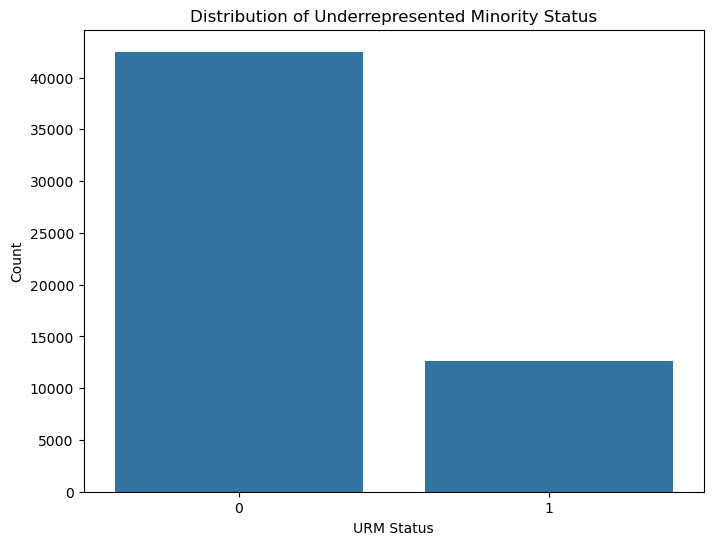

In [18]:
# URM Status Distribution
print("URM Status Distribution:")
print(data['APPLIED URM'].value_counts())

missing_urm = data['APPLIED URM'].isna().sum()
print(f"Missing values in APPLIED URM: {missing_urm} ({(missing_urm/total)*100:.2f}% of the data)")


# Plotting URM status
plt.figure(figsize=(8, 6))
sns.countplot(x='APPLIED URM', data=data)
plt.title('Distribution of Underrepresented Minority Status')
plt.xlabel('URM Status')
plt.ylabel('Count')
plt.show()




## Socioeconomic status

FAFSA Distribution:
FAFSA
1.0    35412
0.0    19735
Name: count, dtype: int64
Missing values in FAFSA: 0 (0.00% of the data)


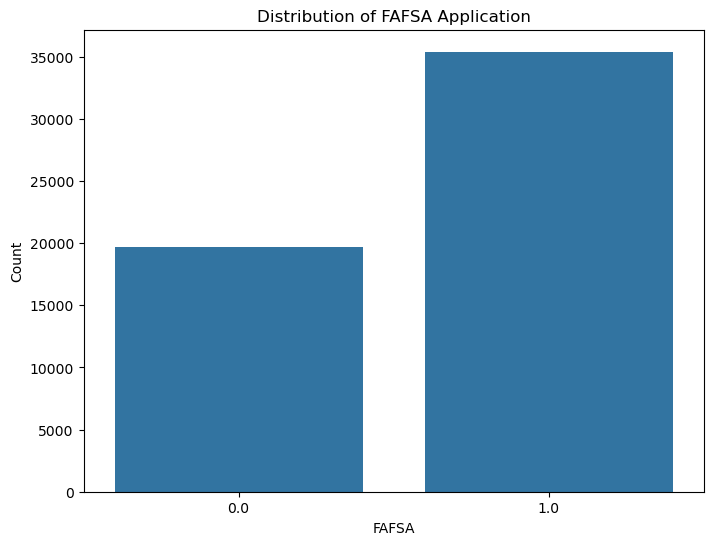

In [19]:
# FAFSA Distribution
print("FAFSA Distribution:")
print(data['FAFSA'].value_counts())

# Checking for missing values in FAFSA
missing_fafsa = data['FAFSA'].isna().sum()
print(f"Missing values in FAFSA: {missing_fafsa} ({(missing_fafsa/total)*100:.2f}% of the data)")

# Plotting FAFSA distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='FAFSA', data=data)
plt.title('Distribution of FAFSA Application')
plt.xlabel('FAFSA')
plt.ylabel('Count')
plt.show()


Fee Waiver Application Distribution:
APPLIED FEE WAIVER ALL
0    45989
1     9158
Name: count, dtype: int64
Missing values in APPLIED FEE WAIVER ALL: 0 (0.00% of the data)


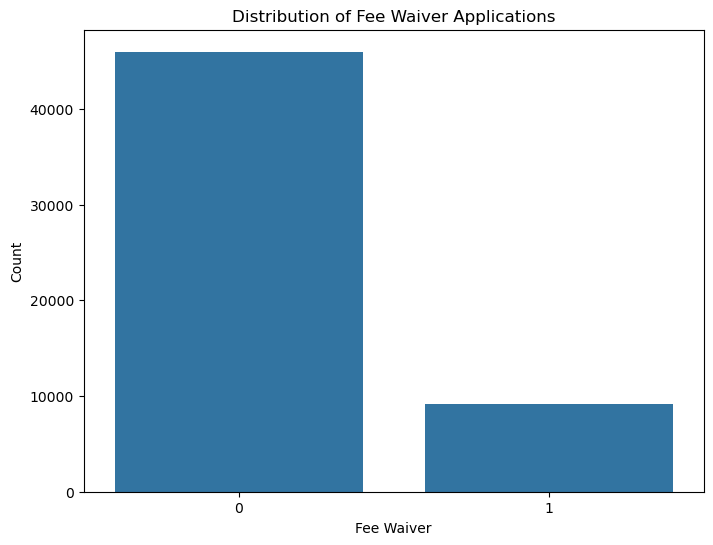

In [20]:
# APPLIED FEE WAIVER ALL Distribution
print("Fee Waiver Application Distribution:")
print(data['APPLIED FEE WAIVER ALL'].value_counts())

# Checking for missing values
missing_fee_waiver = data['APPLIED FEE WAIVER ALL'].isna().sum()
print(f"Missing values in APPLIED FEE WAIVER ALL: {missing_fee_waiver} ({(missing_fee_waiver/total)*100:.2f}% of the data)")

# Plotting the fee waiver application distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='APPLIED FEE WAIVER ALL', data=data)
plt.title('Distribution of Fee Waiver Applications')
plt.xlabel('Fee Waiver')
plt.ylabel('Count')
plt.show()


## Analysis on different student groups

In [21]:
# 1. ZIP Income Level
data['HS ZIP Income Level Encoded_Low'] = data['HS ZIP Income Level Encoded'] == 0
data['HS ZIP Income Level Encoded_Lower_Middle'] = data['HS ZIP Income Level Encoded'] == 1
data['HS ZIP Income Level Encoded_Upper_Middle'] = data['HS ZIP Income Level Encoded'] == 2
data['HS ZIP Income Level Encoded_High'] = data['HS ZIP Income Level Encoded'] == 3

data['ADDR ZIP Income Level Encoded_Low'] = data['ADDR ZIP Income Level Encoded'] == 0
data['ADDR ZIP Income Level Encoded_Lower_Middle'] = data['ADDR ZIP Income Level Encoded'] == 1
data['ADDR ZIP Income Level Encoded_Upper_Middle'] = data['ADDR ZIP Income Level Encoded'] == 2
data['ADDR ZIP Income Level Encoded_High'] = data['ADDR ZIP Income Level Encoded'] == 3

# Convert boolean values to integers (0 or 1)
data[['HS ZIP Income Level Encoded_Low', 'HS ZIP Income Level Encoded_Lower_Middle', 
      'HS ZIP Income Level Encoded_Upper_Middle', 'HS ZIP Income Level Encoded_High',
      'ADDR ZIP Income Level Encoded_Low', 'ADDR ZIP Income Level Encoded_Lower_Middle', 
      'ADDR ZIP Income Level Encoded_Upper_Middle', 'ADDR ZIP Income Level Encoded_High']] = (
    data[['HS ZIP Income Level Encoded_Low', 'HS ZIP Income Level Encoded_Lower_Middle', 
          'HS ZIP Income Level Encoded_Upper_Middle', 'HS ZIP Income Level Encoded_High',
          'ADDR ZIP Income Level Encoded_Low', 'ADDR ZIP Income Level Encoded_Lower_Middle', 
          'ADDR ZIP Income Level Encoded_Upper_Middle', 'ADDR ZIP Income Level Encoded_High']]
    .astype(int)
)

# 2. HS GPA
data['HS GPA below 2.5'] = data['HS GPA'] < 2.5
data['HS GPA 2.5 and above'] = data['HS GPA'] >= 2.5

data[['HS GPA below 2.5', 'HS GPA 2.5 and above']] = data[['HS GPA below 2.5', 'HS GPA 2.5 and above']].astype(int)

# 3. HS AP Units
data['HS AP UNITS Quantile'] = pd.qcut(data['HS AP UNITS'], q=4, labels=[0, 1, 2, 3])

data['HS AP UNITS Low'] = data['HS AP UNITS Quantile'] == 0
data['HS AP UNITS Medium'] = data['HS AP UNITS Quantile'] == 1
data['HS AP UNITS High'] = data['HS AP UNITS Quantile'] == 2
data['HS AP UNITS Very High'] = data['HS AP UNITS Quantile'] == 3

data[['HS AP UNITS Low', 'HS AP UNITS Medium', 'HS AP UNITS High', 'HS AP UNITS Very High']] = (
    data[['HS AP UNITS Low', 'HS AP UNITS Medium', 'HS AP UNITS High', 'HS AP UNITS Very High']].astype(int)
)

# 4. TOTAL HS LANG YEARS TAKEN
data['TOTAL HS LANG YEARS TAKEN 1'] = data['TOTAL HS LANG YEARS TAKEN'] < 2
data['TOTAL HS LANG YEARS TAKEN 2 to 4'] = (data['TOTAL HS LANG YEARS TAKEN'] >= 2) & (data['TOTAL HS LANG YEARS TAKEN'] < 4)
data['TOTAL HS LANG YEARS TAKEN more than 4'] = data['TOTAL HS LANG YEARS TAKEN'] > 4

data[['TOTAL HS LANG YEARS TAKEN 1', 'TOTAL HS LANG YEARS TAKEN 2 to 4', 'TOTAL HS LANG YEARS TAKEN more than 4']] = (
    data[['TOTAL HS LANG YEARS TAKEN 1', 'TOTAL HS LANG YEARS TAKEN 2 to 4', 'TOTAL HS LANG YEARS TAKEN more than 4']]
    .astype(int)
)
key_columns_modeling_revised = [
    'Gender_F',
    'Gender_M', 
    'APPLIED FIRST GENERATION',
    'Race_African American or Black', 
    'Race_American-Indian', 
    'Race_Asian', 
    'Race_Hispanic or Latino',
    'Race_NHPI', 
    'Race_White',
    'APPLIED FEE WAIVER ALL', 
    'FAFSA',
    'APPLIED URM',
    
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',
    'HS ZIP Income Level Encoded', 
    'ADDR ZIP Income Level Encoded',

    'HS ZIP Income Level Encoded_Low',
    'HS ZIP Income Level Encoded_Lower_Middle',
    'HS ZIP Income Level Encoded_Upper_Middle',
    'HS ZIP Income Level Encoded_High',
    
    'ADDR ZIP Income Level Encoded_Low',
    'ADDR ZIP Income Level Encoded_Lower_Middle',
    'ADDR ZIP Income Level Encoded_Upper_Middle',
    'ADDR ZIP Income Level Encoded_High',

    'HS GPA below 2.5',
    'HS GPA 2.5 and above',

    'HS AP UNITS Low',
    'HS AP UNITS Medium',
    'HS AP UNITS High',
    'HS AP UNITS Very High',

    'TOTAL HS LANG YEARS TAKEN 1',
    'TOTAL HS LANG YEARS TAKEN 2 to 4',
    'TOTAL HS LANG YEARS TAKEN more than 4',

]

graduation_rates_by_column = {}

for column in key_columns_modeling_revised:
    if data[column].nunique() == 2:
        graduation_rate = data[data[column] == 1]['DEGREE ACHIEVED'].mean()
        graduation_rates_by_column[column] = graduation_rate

graduation_rates_df = pd.DataFrame(list(graduation_rates_by_column.items()), columns=['Column', 'Graduation Rate'])
graduation_rates_df = graduation_rates_df.sort_values(by='Graduation Rate', ascending=False)

graduation_rates_df




,Column,Graduation Rate
28,TOTAL HS LANG YEARS TAKEN more than 4,0.869121
8,Race_White,0.863283
19,ADDR ZIP Income Level Encoded_High,0.860069
5,Race_Asian,0.859164
15,HS ZIP Income Level Encoded_High,0.857918
0,Gender_F,0.856369
25,HS AP UNITS Very High,0.848320
24,HS AP UNITS High,0.845267
23,HS AP UNITS Medium,0.837612
21,HS GPA 2.5 and above,0.836101


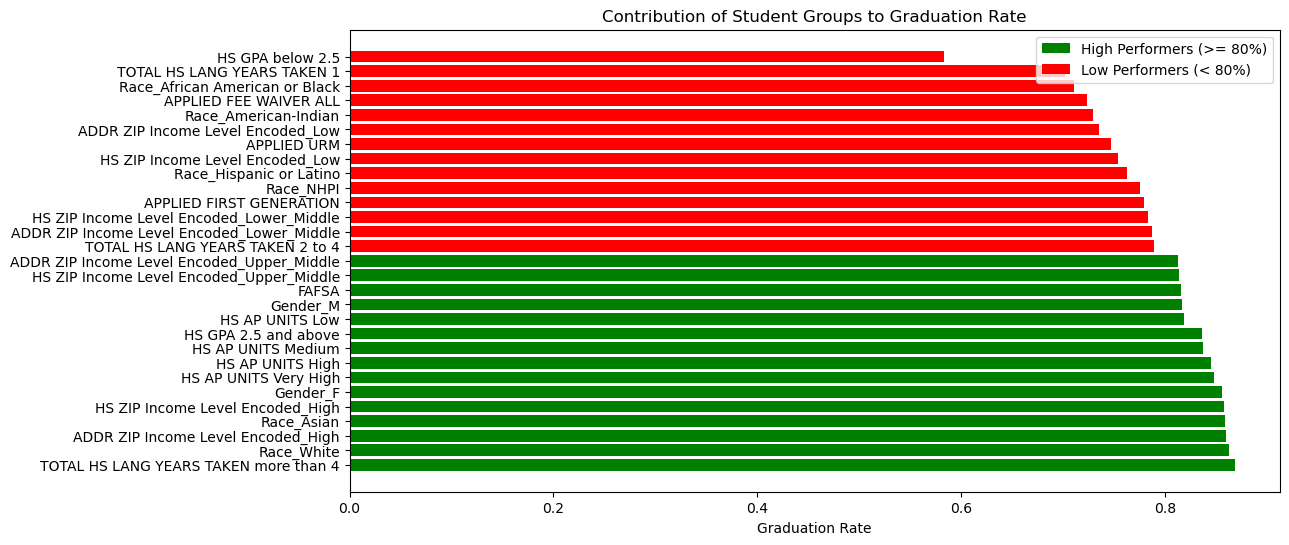

In [22]:
high_performers = graduation_rates_df[graduation_rates_df['Graduation Rate'] >= 0.8]
low_performers = graduation_rates_df[graduation_rates_df['Graduation Rate'] < 0.8]

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(high_performers['Column'], high_performers['Graduation Rate'], label='High Performers (>= 80%)', color='green')
ax.barh(low_performers['Column'], low_performers['Graduation Rate'], label='Low Performers (< 80%)', color='red')
ax.set_xlabel('Graduation Rate')
ax.set_title('Contribution of Student Groups to Graduation Rate')
ax.legend()
plt.show()


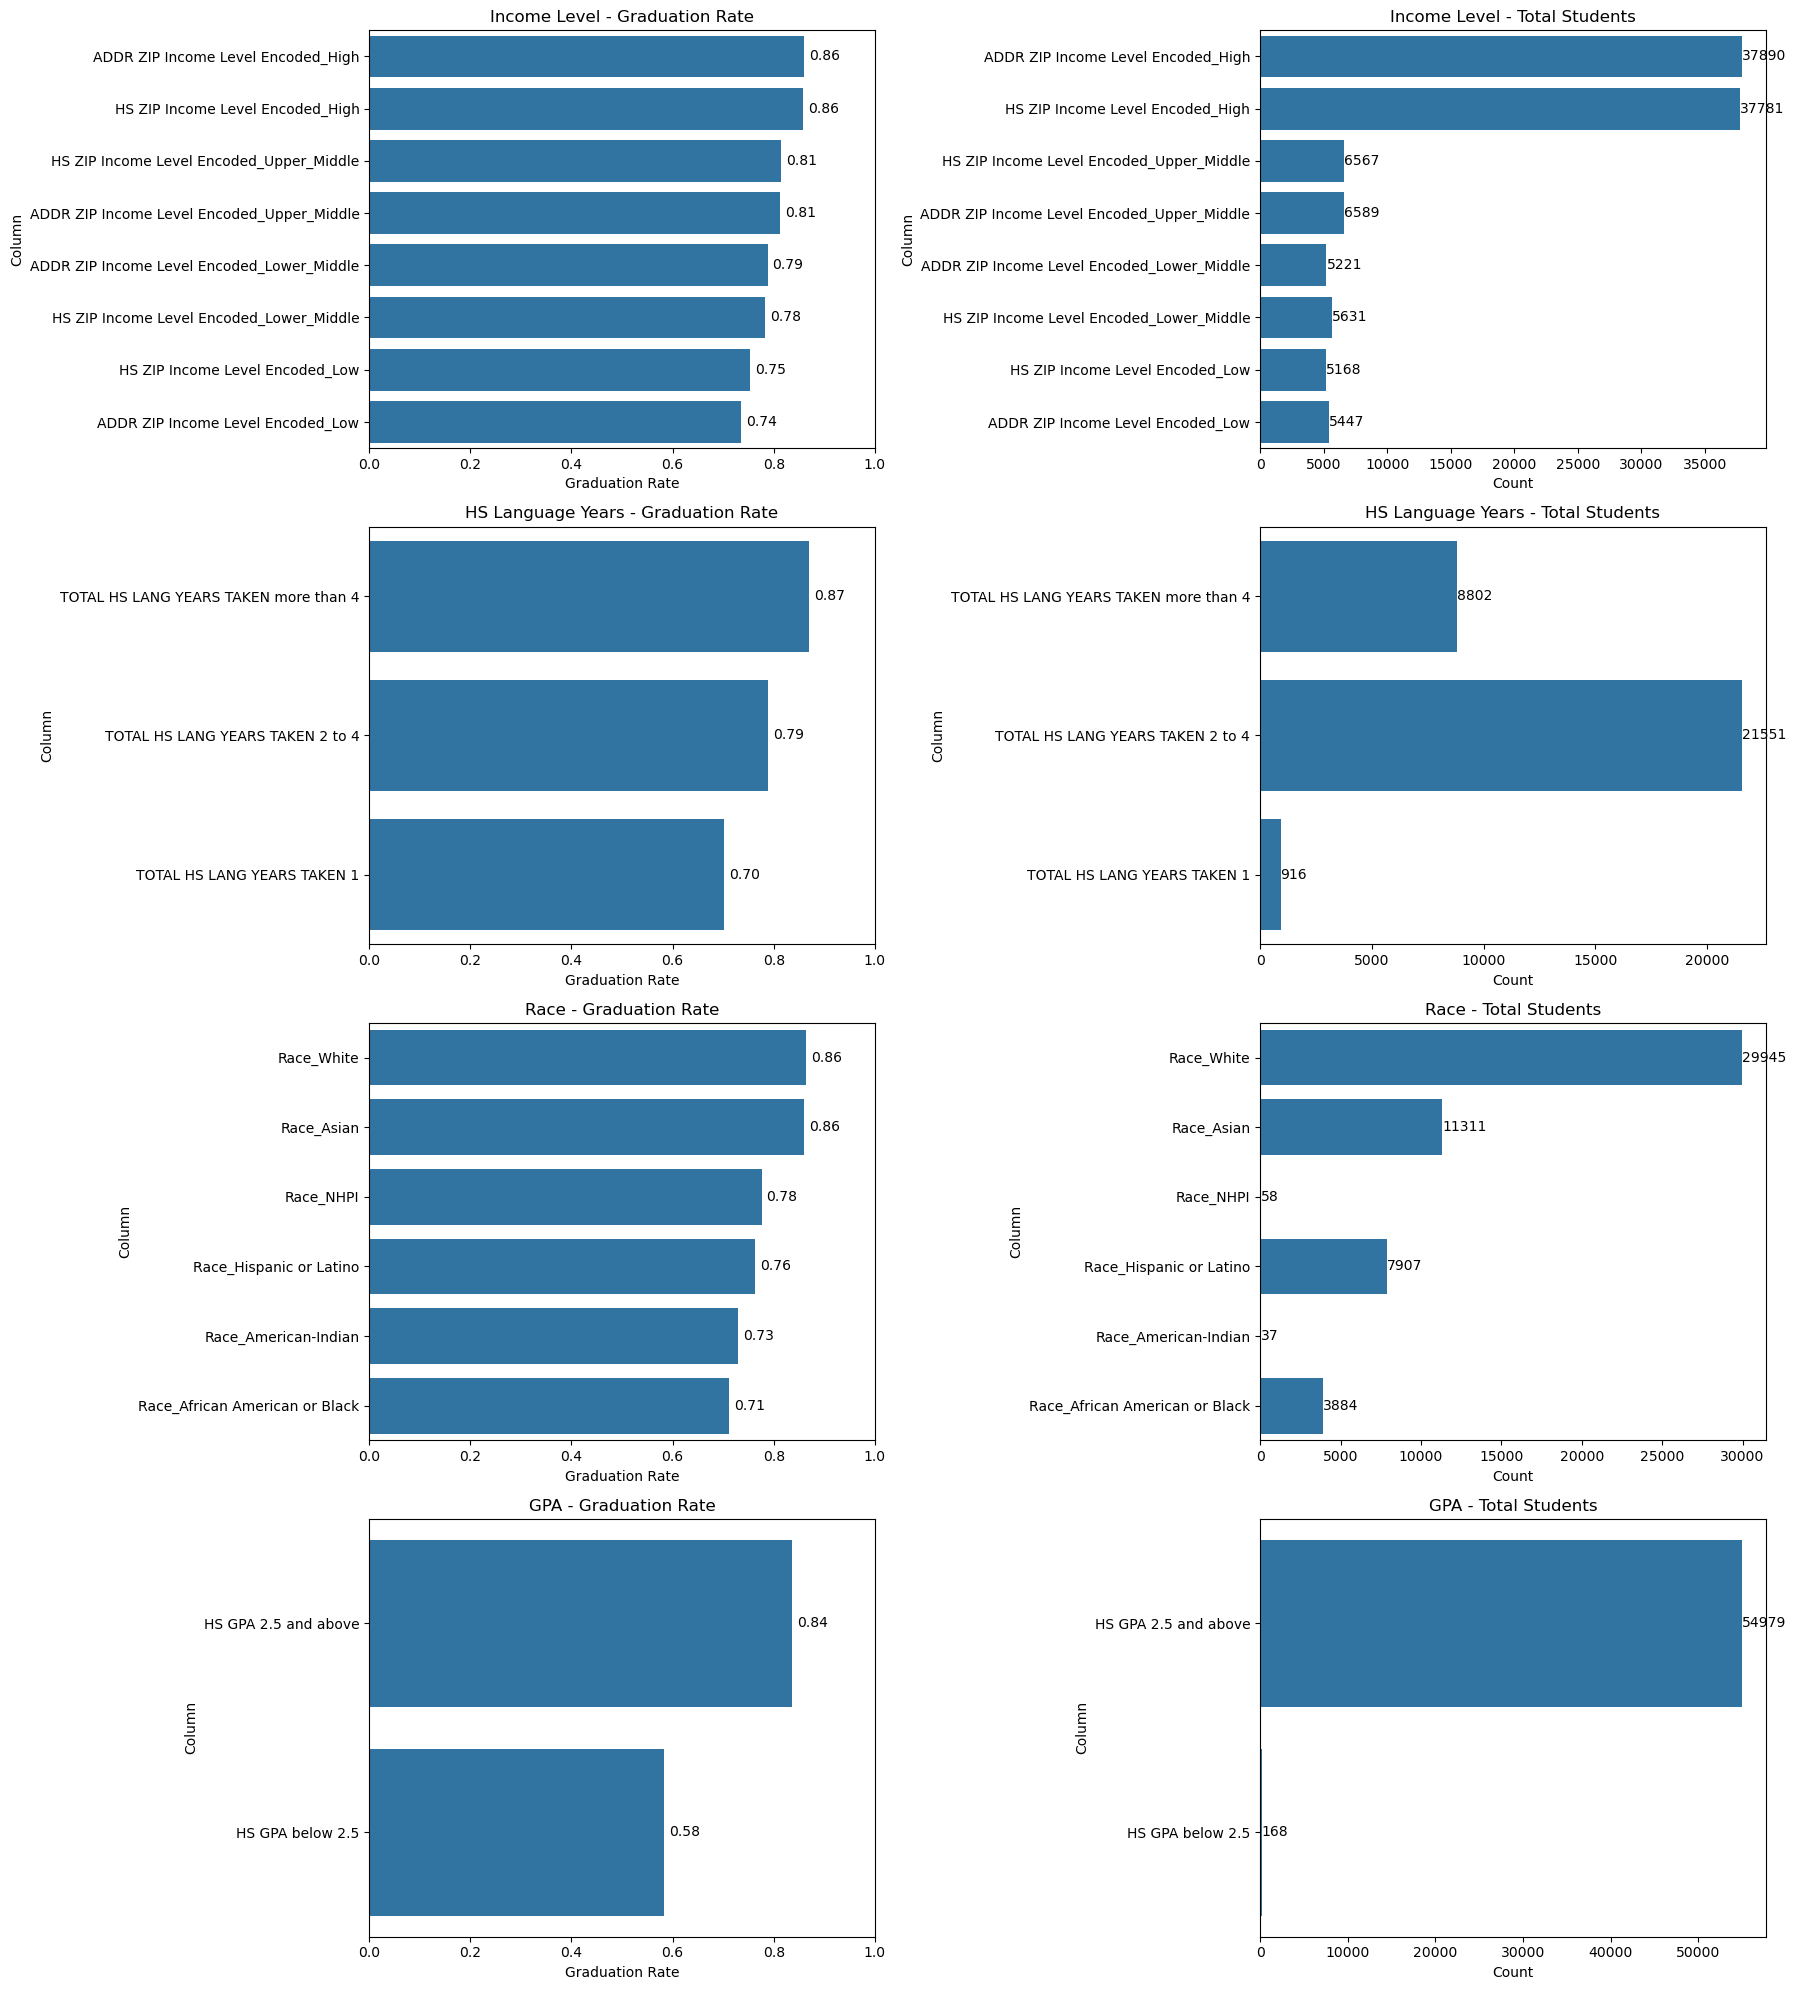

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
graduation_rates_by_column = {}

for column in key_columns_modeling_revised:
    if data[column].nunique() == 2:
        graduation_rate = data[data[column] == 1]['DEGREE ACHIEVED'].mean()
        count = data[data[column] == 1].shape[0]
        graduation_rates_by_column[column] = {'Graduation Rate': graduation_rate, 'Count': count}

graduation_rates_df = pd.DataFrame.from_dict(graduation_rates_by_column, orient='index').reset_index()
graduation_rates_df.columns = ['Column', 'Graduation Rate', 'Count']

graduation_rates_df = graduation_rates_df.sort_values(by='Graduation Rate', ascending=False)


# Create the subplots with combined graduation rate and count side by side for each group
fig, axes = plt.subplots(4, 2, figsize=(18, 20))

# Function to plot rate and count side by side
def plot_combined(data, title, column_filter, ax_rate, ax_count):
    # Filter data based on the column_filter
    filtered_data = data[data['Column'].str.contains(column_filter, case=False)]
    
    if 'Count' in filtered_data.columns:
        # Graduation Rate Plot
        sns.barplot(data=filtered_data, y='Column', x='Graduation Rate', ax=ax_rate)
        for index, value in enumerate(filtered_data['Graduation Rate']):
            ax_rate.text(value + 0.01, index, f"{value:.2f}", color='black', va="center")
        ax_rate.set_title(f'{title} - Graduation Rate')
        ax_rate.set_xlim(0, 1)

        # Count Plot
        sns.barplot(data=filtered_data, y='Column', x='Count', ax=ax_count)
        for index, value in enumerate(filtered_data['Count']):
            ax_count.text(value + 0.01, index, f"{value}", color='black', va="center")
        ax_count.set_title(f'{title} - Total Students')

# Plotting for each category
plot_combined(graduation_rates_df, 'Income Level', 'Income Level', axes[0, 0], axes[0, 1])
plot_combined(graduation_rates_df, 'HS Language Years', 'HS LANG YEARS', axes[1, 0], axes[1, 1])
plot_combined(graduation_rates_df, 'Race', 'Race', axes[2, 0], axes[2, 1])
plot_combined(graduation_rates_df, 'GPA', 'GPA', axes[3, 0], axes[3, 1])

plt.tight_layout()
plt.show()


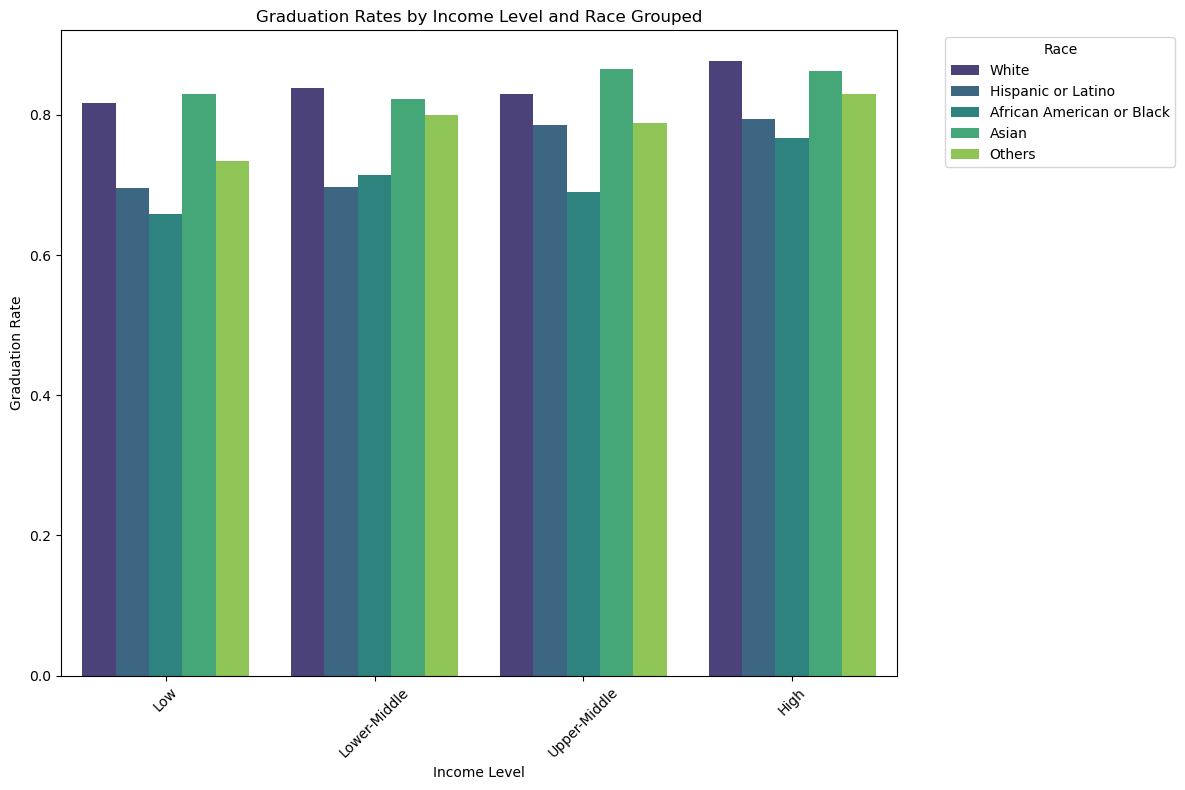

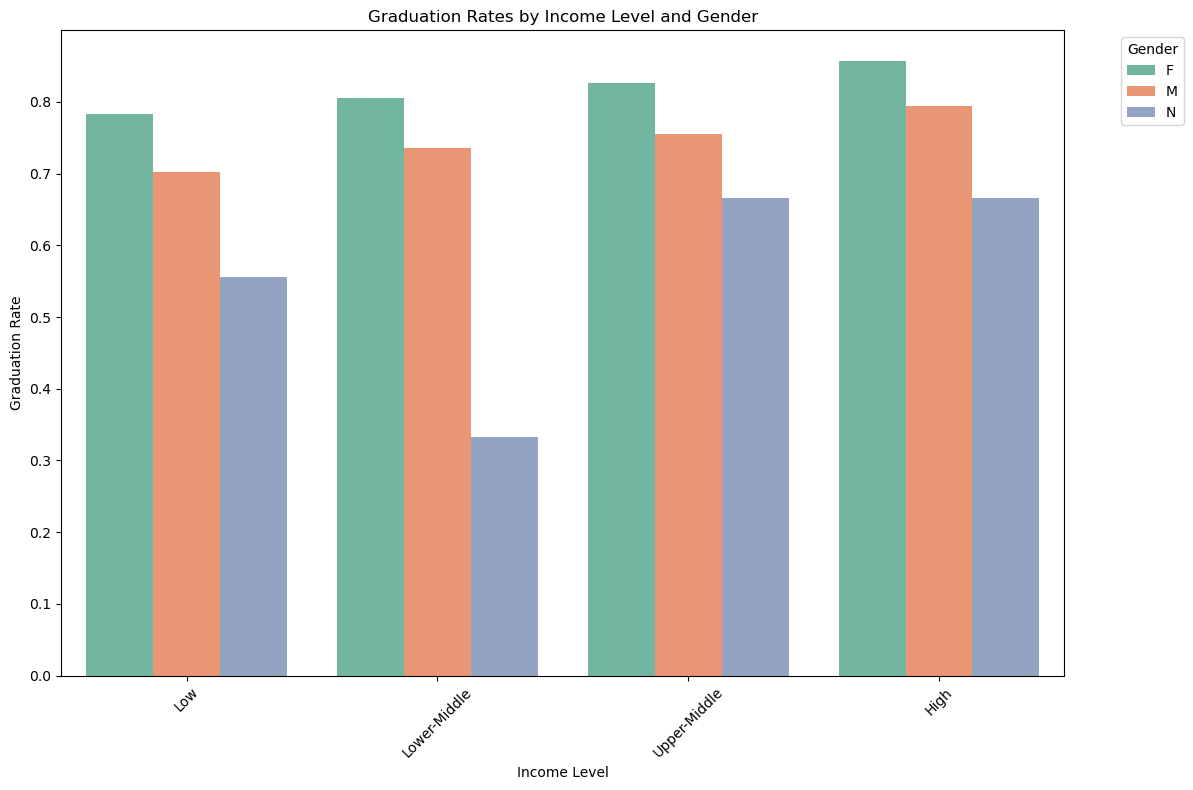

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
data['Race Grouped'] = data['APPLIED RACE ETH ONE'].replace({
    'Asian': 'Asian',
    'White': 'White',
    'Hispanic or Latino': 'Hispanic or Latino',
    'African American or Black': 'African American or Black'
})
data['Race Grouped'] = data['Race Grouped'].apply(lambda x: x if x in ['Asian', 'White', 'Hispanic or Latino', 'African American or Black'] else 'Others')


income_race_combination = data.groupby(['HS ZIP Income Level', 'Race Grouped', 'APPLIED GENDER CD']).agg({
    'DEGREE ACHIEVED': 'mean'
}).reset_index()

income_race_combination.columns = ['HS ZIP Income Level', 'Race Grouped', 'APPLIED GENDER CD', 'Graduated']




# Update the income and race combination visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='HS ZIP Income Level', y='DEGREE ACHIEVED', hue='Race Grouped', estimator='mean', palette='viridis', ci=None, order=['Low', 'Lower-Middle', 'Upper-Middle', 'High'])
plt.title('Graduation Rates by Income Level and Race Grouped')
plt.xlabel('Income Level')
plt.ylabel('Graduation Rate')
plt.xticks(rotation=45)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# b. Income Level and Gender Graduation Rate Comparison (Side-by-Side Bar Chart)
plt.figure(figsize=(12, 8))
sns.barplot(data=income_race_combination, x='HS ZIP Income Level', y='Graduated', hue='APPLIED GENDER CD', estimator='mean', palette='Set2', order=income_order, ci = None)
plt.title('Graduation Rates by Income Level and Gender')
plt.xlabel('Income Level')
plt.ylabel('Graduation Rate')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


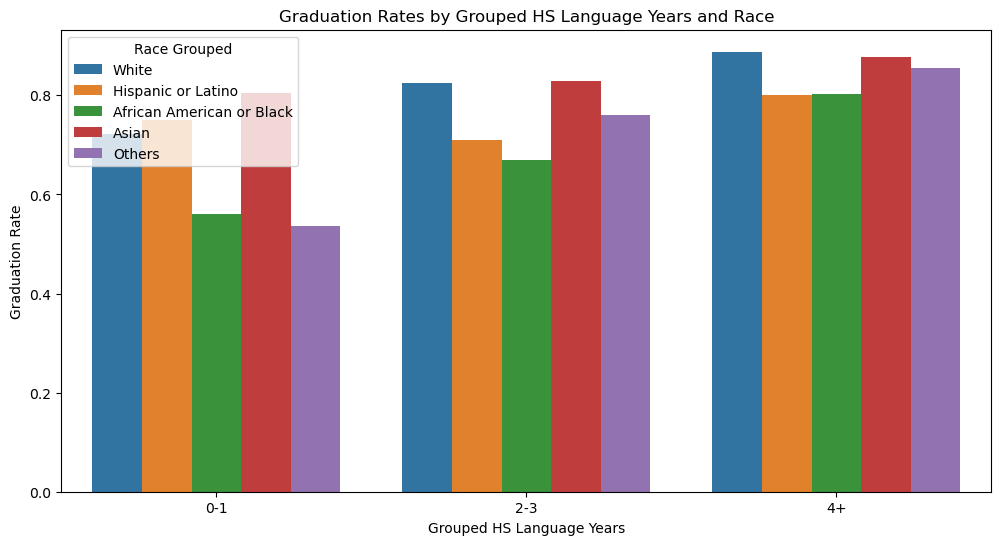

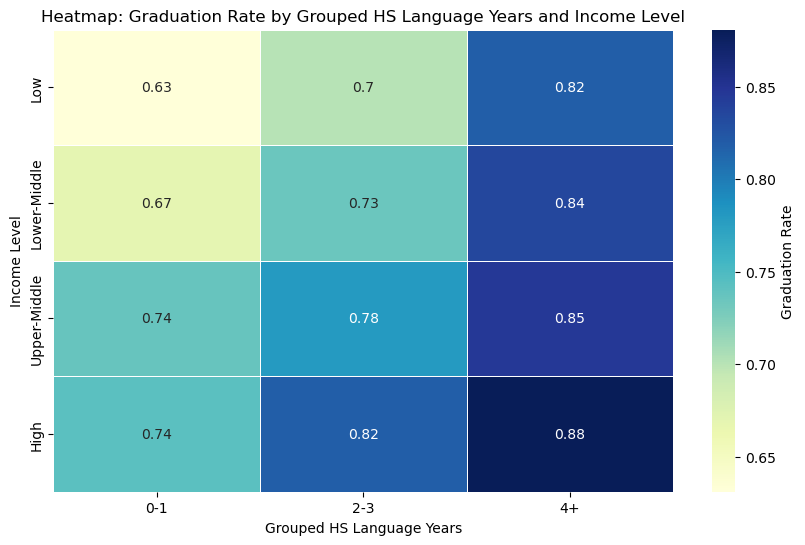

In [31]:

# 2. High School Language Years
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming data is preprocessed as per earlier instructions, including graduation_rates_df creation

# Group HS Language Years into broader bins
bins = [0, 1, 3, float('inf')]
labels = ['0-1', '2-3', '4+']
data['HS LANG YEARS BINNED'] = pd.cut(data['TOTAL HS LANG YEARS TAKEN'], bins=bins, labels=labels)

# 1. Bar Chart: Graduation Rate by Grouped HS Language Years and Race Grouped
plt.figure(figsize=(12, 6))
sns.barplot(
    data=data,
    x='HS LANG YEARS BINNED',
    y='DEGREE ACHIEVED',
    hue='Race Grouped',
    ci=None
)
plt.title('Graduation Rates by Grouped HS Language Years and Race')
plt.xlabel('Grouped HS Language Years')
plt.ylabel('Graduation Rate')
plt.legend(title='Race Grouped')
plt.show()

# 2. Heatmap: Average Graduation Rate by Grouped HS Language Years and Income Level
pivot_table = data.pivot_table(values='DEGREE ACHIEVED', index='HS ZIP Income Level', columns='HS LANG YEARS BINNED', aggfunc='mean')

# Reorder the index so that it goes from Low to High
ordered_index = ['Low', 'Lower-Middle', 'Upper-Middle', 'High']
pivot_table = pivot_table.reindex(ordered_index)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Graduation Rate'}, linewidths=0.5)
plt.title('Heatmap: Graduation Rate by Grouped HS Language Years and Income Level')
plt.xlabel('Grouped HS Language Years')
plt.ylabel('Income Level')
plt.show()

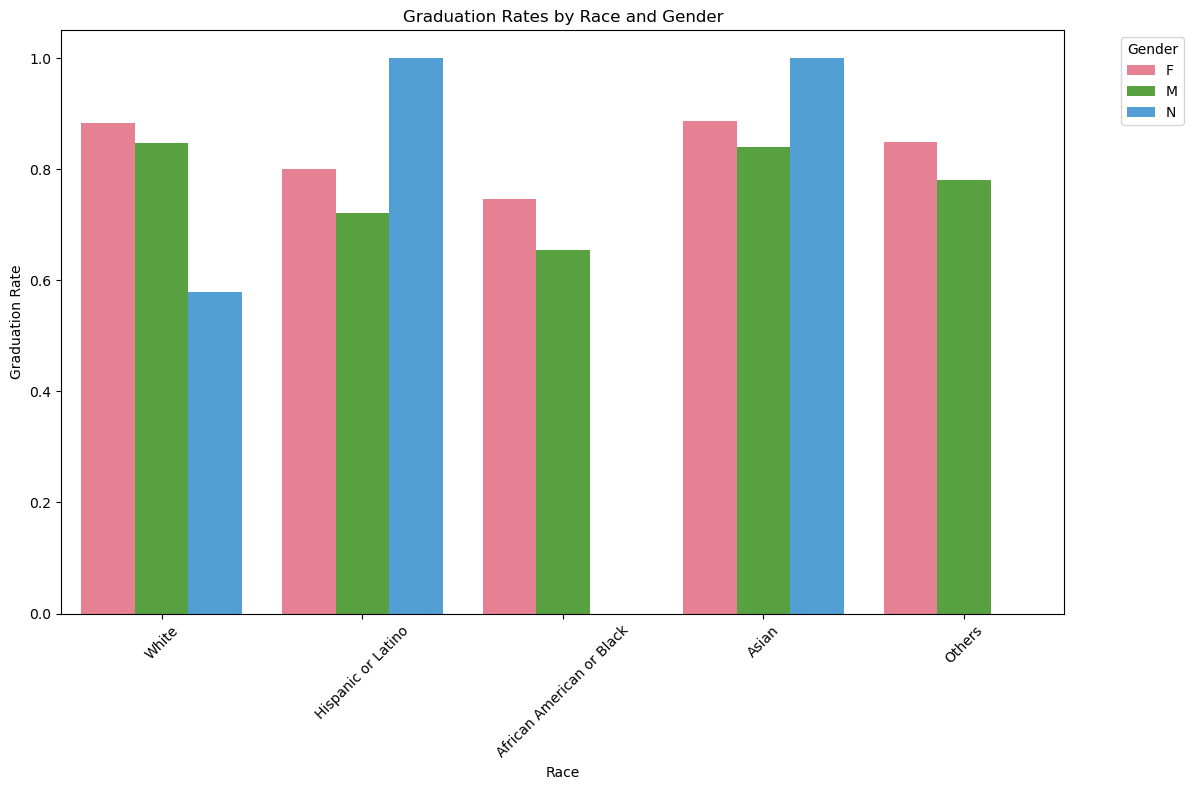

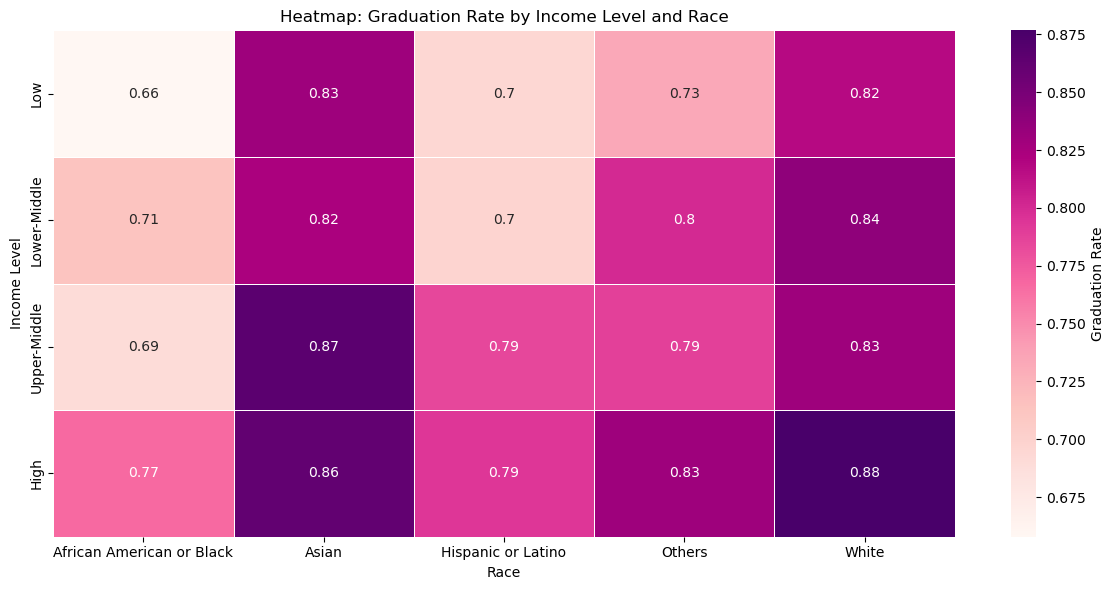

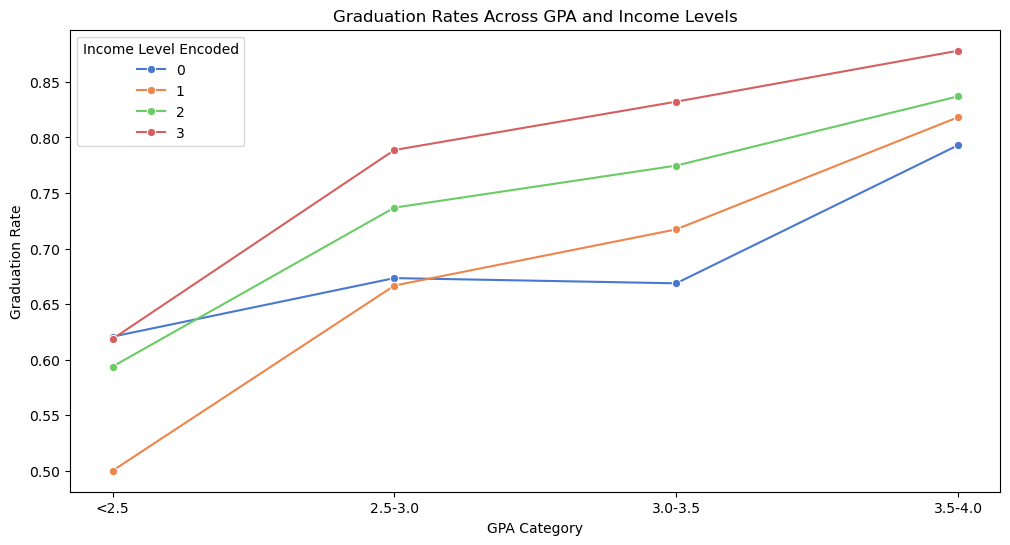

In [32]:

# 3. Race Combinations
# a. Race and Gender Graduation Rates (Grouped Bar Chart)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=data,
    x='Race Grouped',
    y='DEGREE ACHIEVED',
    hue='APPLIED GENDER CD',
    estimator='mean',
    palette='husl',
    ci=None
    # order=race_order
)
plt.title('Graduation Rates by Race and Gender')
plt.xlabel('Race')
plt.ylabel('Graduation Rate')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# b. Race and Income Level Graduation Rates (Heatmap)
race_income_heatmap_data = data.pivot_table(values='DEGREE ACHIEVED', index='HS ZIP Income Level', columns='Race Grouped', aggfunc='mean')
race_income_heatmap_data = race_income_heatmap_data.loc[income_order]

plt.figure(figsize=(12, 6))
sns.heatmap(race_income_heatmap_data, annot=True, cmap='RdPu', linewidths=0.5, cbar_kws={'label': 'Graduation Rate'})
plt.title('Heatmap: Graduation Rate by Income Level and Race')
plt.xlabel('Race')
plt.ylabel('Income Level')
plt.tight_layout()
plt.show()

# Create a new GPA category
data['GPA Category'] = pd.cut(data['HS GPA'], bins=[0, 2.5, 3.0, 3.5, 4.0], labels=['<2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0'])

# Calculate graduation rates across GPA and Income Level
trend_data = data.groupby(['GPA Category', 'HS ZIP Income Level Encoded']).agg({'DEGREE ACHIEVED': 'mean'}).reset_index()

# Plot the trend line
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x='GPA Category', y='DEGREE ACHIEVED', hue='HS ZIP Income Level Encoded', marker='o', palette='muted')
plt.title('Graduation Rates Across GPA and Income Levels')
plt.ylabel('Graduation Rate')
plt.xlabel('GPA Category')
plt.legend(title='Income Level Encoded')
plt.show()

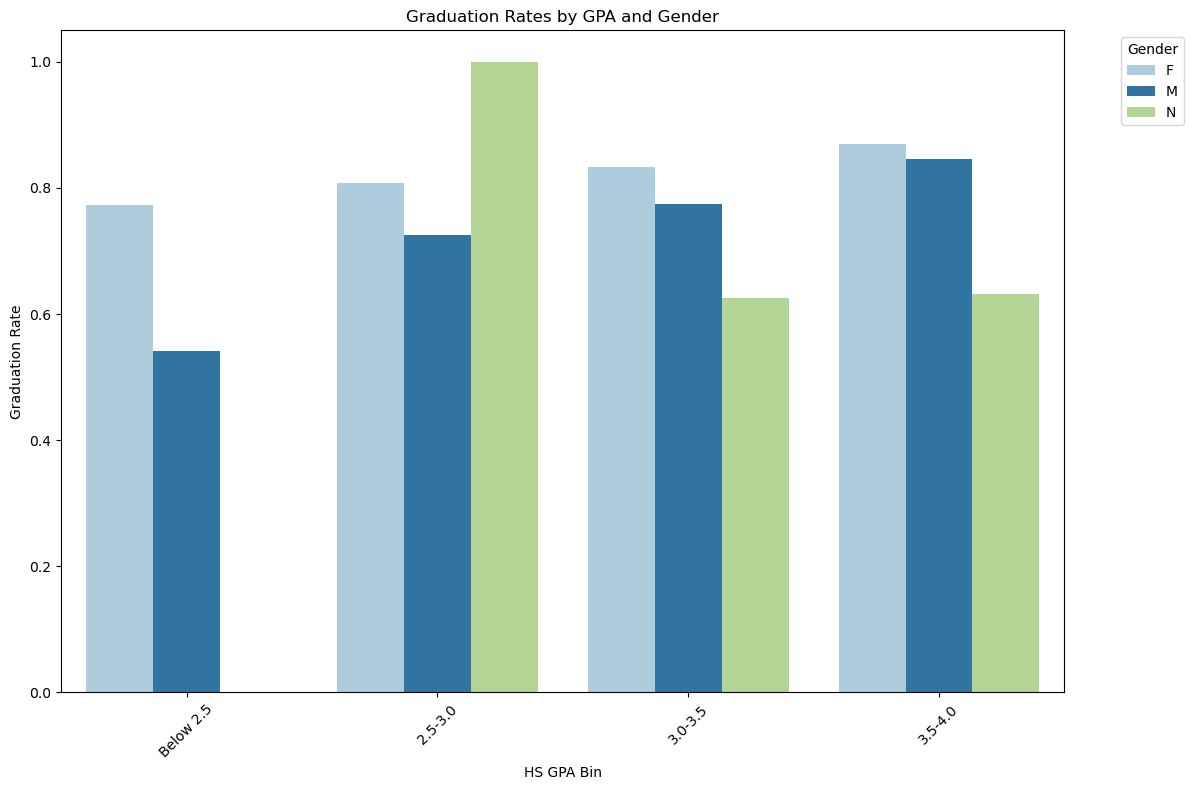

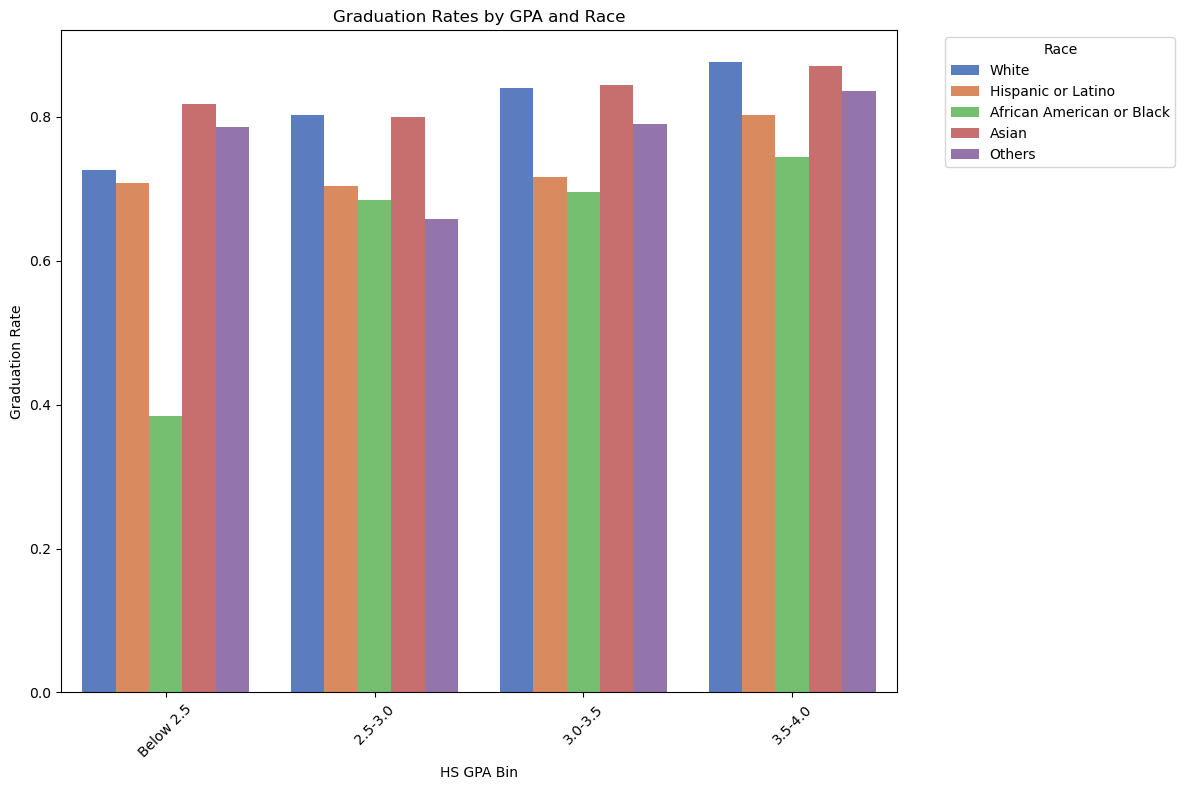

In [33]:
# Binning the GPA values
data['HS GPA Bin'] = pd.cut(data['HS GPA'], bins=[0, 2.5, 3.0, 3.5, 4.0], labels=['Below 2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0'])

# Creating the bar plot with GPA bins and gender graduation rates
plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='HS GPA Bin', y='DEGREE ACHIEVED', hue='APPLIED GENDER CD', palette='Paired', ci=None)
plt.title('Graduation Rates by GPA and Gender')
plt.xlabel('HS GPA Bin')
plt.ylabel('Graduation Rate')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='HS GPA Bin', y='DEGREE ACHIEVED', hue='Race Grouped', estimator='mean', palette='muted', ci=None)
plt.title('Graduation Rates by GPA and Race')
plt.xlabel('HS GPA Bin')
plt.ylabel('Graduation Rate')
plt.xticks(rotation=45)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Modeling

## First Stages

During the first few weeks of the internship we focused on traditional and simple machine learning models

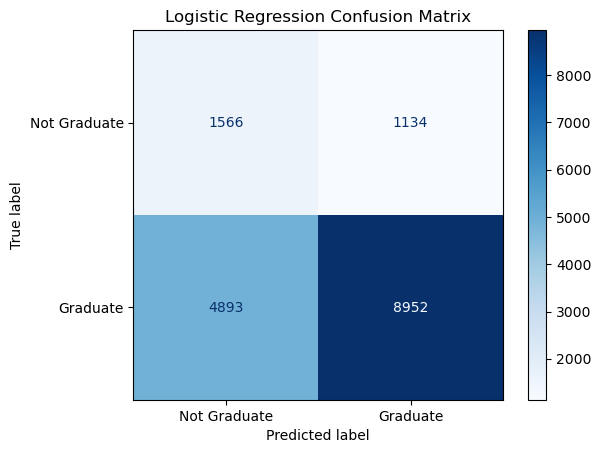

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.24      0.58      0.34      2700
           1       0.89      0.65      0.75     13845

    accuracy                           0.64     16545
   macro avg       0.57      0.61      0.55     16545
weighted avg       0.78      0.64      0.68     16545

AUC Score: 0.653




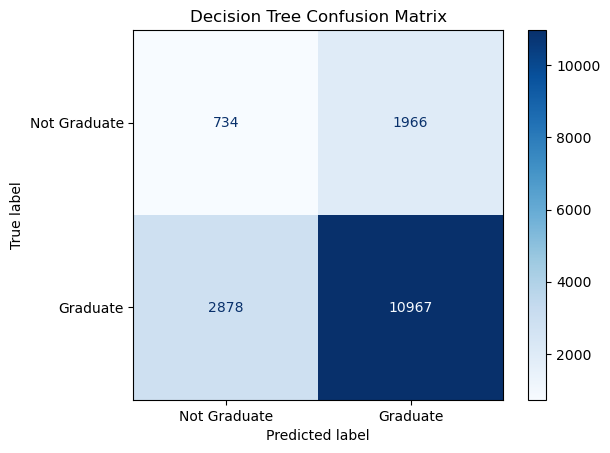

Results for Decision Tree:
              precision    recall  f1-score   support

           0       0.20      0.27      0.23      2700
           1       0.85      0.79      0.82     13845

    accuracy                           0.71     16545
   macro avg       0.53      0.53      0.53     16545
weighted avg       0.74      0.71      0.72     16545

AUC Score: 0.524




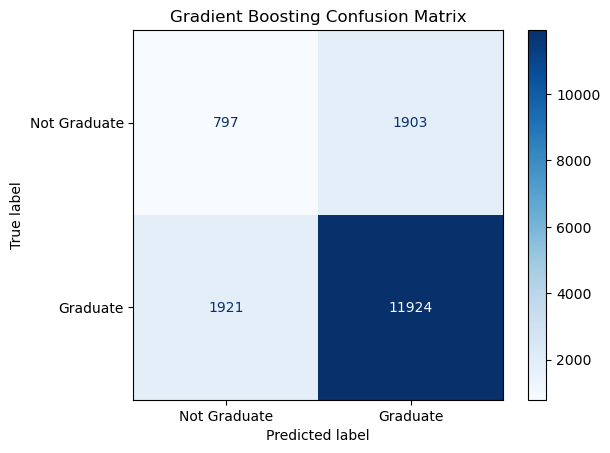

Results for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.29      0.30      0.29      2700
           1       0.86      0.86      0.86     13845

    accuracy                           0.77     16545
   macro avg       0.58      0.58      0.58     16545
weighted avg       0.77      0.77      0.77     16545

AUC Score: 0.632




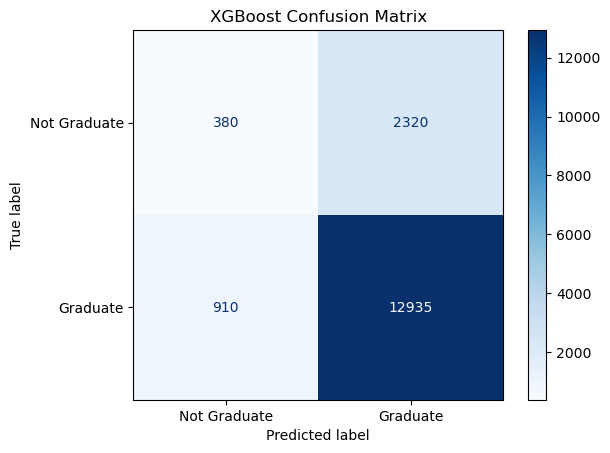

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.29      0.14      0.19      2700
           1       0.85      0.93      0.89     13845

    accuracy                           0.80     16545
   macro avg       0.57      0.54      0.54     16545
weighted avg       0.76      0.80      0.78     16545

AUC Score: 0.599




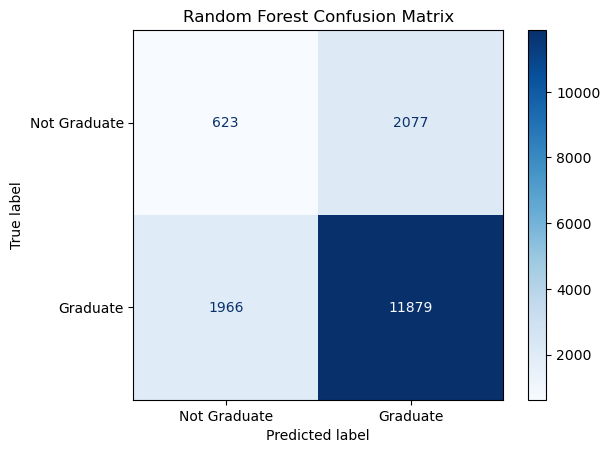

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.24      0.23      0.24      2700
           1       0.85      0.86      0.85     13845

    accuracy                           0.76     16545
   macro avg       0.55      0.54      0.55     16545
weighted avg       0.75      0.76      0.75     16545

AUC Score: 0.598




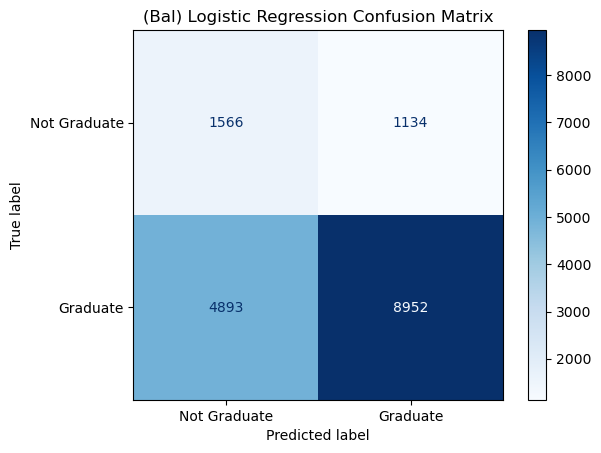

Results for (Bal) Logistic Regression:
              precision    recall  f1-score   support

           0       0.24      0.58      0.34      2700
           1       0.89      0.65      0.75     13845

    accuracy                           0.64     16545
   macro avg       0.57      0.61      0.55     16545
weighted avg       0.78      0.64      0.68     16545

AUC Score: 0.653




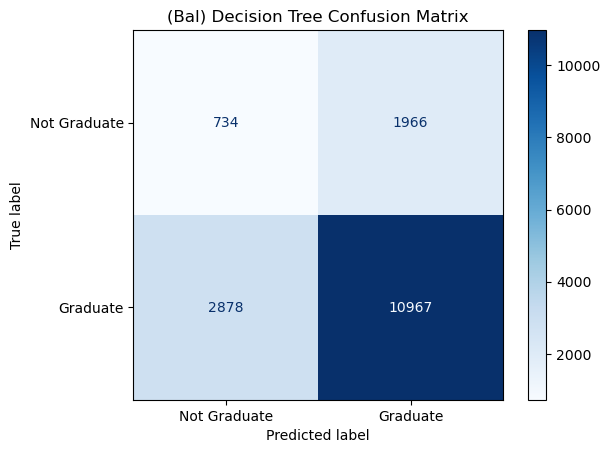

Results for (Bal) Decision Tree:
              precision    recall  f1-score   support

           0       0.20      0.27      0.23      2700
           1       0.85      0.79      0.82     13845

    accuracy                           0.71     16545
   macro avg       0.53      0.53      0.53     16545
weighted avg       0.74      0.71      0.72     16545

AUC Score: 0.524




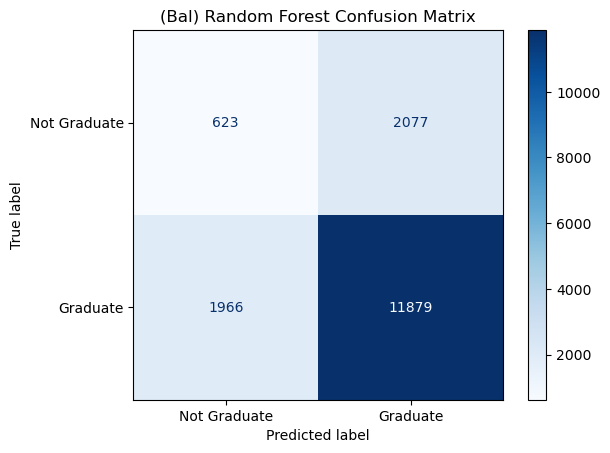

Results for (Bal) Random Forest:
              precision    recall  f1-score   support

           0       0.24      0.23      0.24      2700
           1       0.85      0.86      0.85     13845

    accuracy                           0.76     16545
   macro avg       0.55      0.54      0.55     16545
weighted avg       0.75      0.76      0.75     16545

AUC Score: 0.598




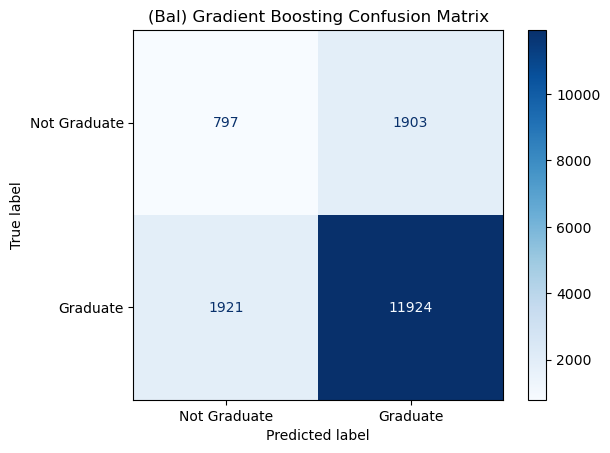

Results for (Bal) Gradient Boosting:
              precision    recall  f1-score   support

           0       0.29      0.30      0.29      2700
           1       0.86      0.86      0.86     13845

    accuracy                           0.77     16545
   macro avg       0.58      0.58      0.58     16545
weighted avg       0.77      0.77      0.77     16545

AUC Score: 0.632




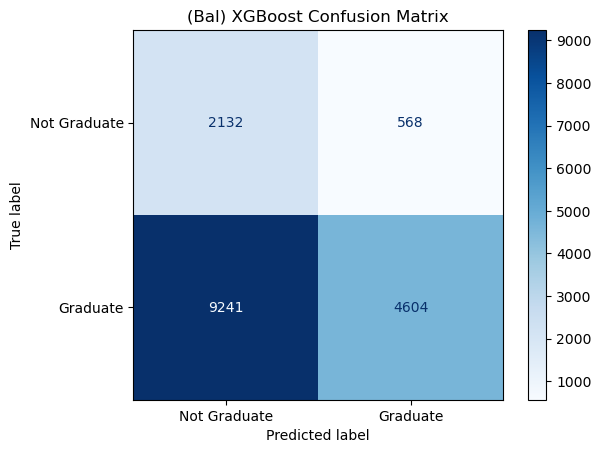

Results for (Bal) XGBoost:
              precision    recall  f1-score   support

           0       0.19      0.79      0.30      2700
           1       0.89      0.33      0.48     13845

    accuracy                           0.41     16545
   macro avg       0.54      0.56      0.39     16545
weighted avg       0.78      0.41      0.45     16545

AUC Score: 0.602




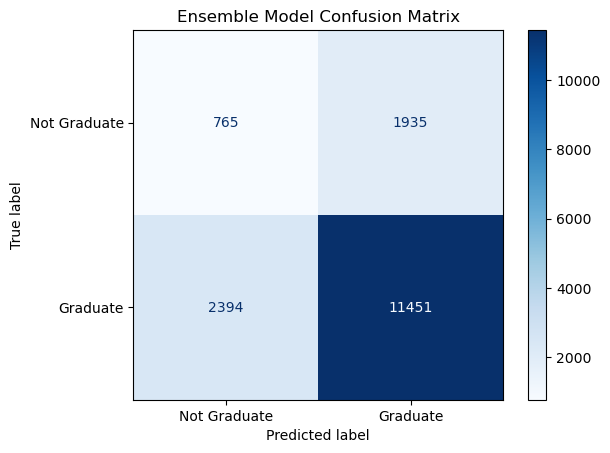

Ensemble Model Results:
              precision    recall  f1-score   support

           0       0.24      0.28      0.26      2700
           1       0.86      0.83      0.84     13845

    accuracy                           0.74     16545
   macro avg       0.55      0.56      0.55     16545
weighted avg       0.76      0.74      0.75     16545

Ensemble AUC Score: 0.614

Summary of AUC Scores (All Predictors):
                        Model  AUC Score
0         Logistic Regression   0.653293
1               Decision Tree   0.523914
2           Gradient Boosting   0.632297
3                     XGBoost   0.599205
4               Random Forest   0.597515
5   (Bal) Logistic Regression   0.653293
6         (Bal) Decision Tree   0.523914
7         (Bal) Random Forest   0.597515
8     (Bal) Gradient Boosting   0.632297
9               (Bal) XGBoost   0.602155
10                   Ensemble   0.614306


In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

key_columns = [
    # Demographic
    'APPLIED FIRST GENERATION',
    'Race_Asian', 
    'Race_White',
    'Race_African American or Black', 
    'Race_American-Indian', 
    'Race_Hispanic or Latino',
    'Race_NHPI', 
    'APPLIED URM',
    'Gender_F',
    'Gender_M', 

    # Academic Performance
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',

    # Socioeconomic Indicators
    'HS ZIP Income Level Encoded', 
    'ADDR ZIP Income Level Encoded',
    'APPLIED FEE WAIVER ALL',
    'FAFSA'
]

X = data[key_columns]
y = data['DEGREE ACHIEVED']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "(Bal) Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "(Bal) Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "(Bal) Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "(Bal) Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "(Bal) XGBoost": XGBClassifier(scale_pos_weight=len(y[y == 0]) / len(y[y == 1]), random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Dictionary to store results
results = {}

# Train each model and collect performance metrics
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Graduate", "Graduate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    # Classification report and AUC score
    report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_probs)
    results[model_name] = {"Classification Report": report, "AUC Score": auc_score}
    
    print(f"Results for {model_name}:")
    print(report)
    print(f"AUC Score: {auc_score:.3f}")
    print("\n" + "=" * 50 + "\n")

# Ensemble Model - Soft Voting Classifier
# Use all models with probability voting
ensemble_model = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

ensemble_model.fit(X_train_resampled, y_train_resampled)
y_ensemble_pred = ensemble_model.predict(X_test)
y_ensemble_pred_probs = ensemble_model.predict_proba(X_test)[:, 1]

# Ensemble performance metrics
ensemble_report = classification_report(y_test, y_ensemble_pred)
ensemble_auc_score = roc_auc_score(y_test, y_ensemble_pred_probs)

# Display ensemble confusion matrix
cm = confusion_matrix(y_test, y_ensemble_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Graduate", "Graduate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ensemble Model Confusion Matrix")
plt.show()

# Display ensemble results
print("Ensemble Model Results:")
print(ensemble_report)
print(f"Ensemble AUC Score: {ensemble_auc_score:.3f}")

# Summary Table
summary_df = pd.DataFrame({
    "Model": list(results.keys()) + ["Ensemble"],
    "AUC Score": [results[model_name]["AUC Score"] for model_name in results.keys()] + [ensemble_auc_score]
})

print("\nSummary of AUC Scores (All Predictors):")
print(summary_df)


Some key points to keep in mind:
- The metrics used to measure performance of the models are displayed for each model
    - We are mainly interested in the classification report and AUC as accuracy measures for classification problems like these. 
- The data is heavily imbalanced
    - Therefore, we use balanced versions of each model to see if there are any improvements to the overall score.
  

### Trying different class balancing techniques

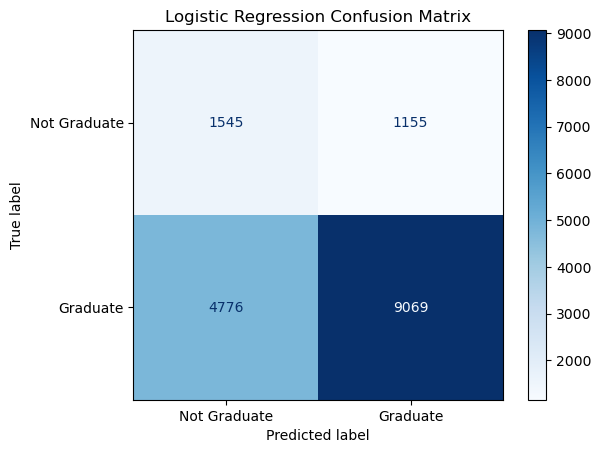

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.24      0.57      0.34      2700
           1       0.89      0.66      0.75     13845

    accuracy                           0.64     16545
   macro avg       0.57      0.61      0.55     16545
weighted avg       0.78      0.64      0.69     16545

AUC Score: 0.653




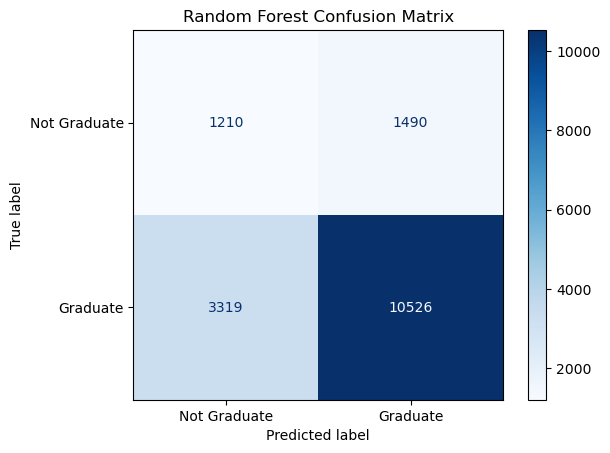

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.27      0.45      0.33      2700
           1       0.88      0.76      0.81     13845

    accuracy                           0.71     16545
   macro avg       0.57      0.60      0.57     16545
weighted avg       0.78      0.71      0.74     16545

AUC Score: 0.647




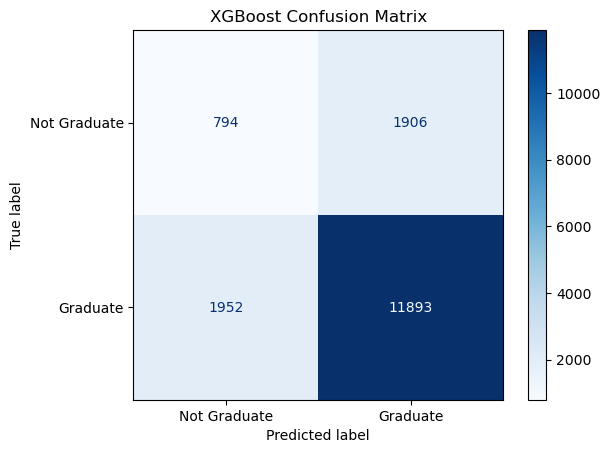

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29      2700
           1       0.86      0.86      0.86     13845

    accuracy                           0.77     16545
   macro avg       0.58      0.58      0.58     16545
weighted avg       0.77      0.77      0.77     16545

AUC Score: 0.629




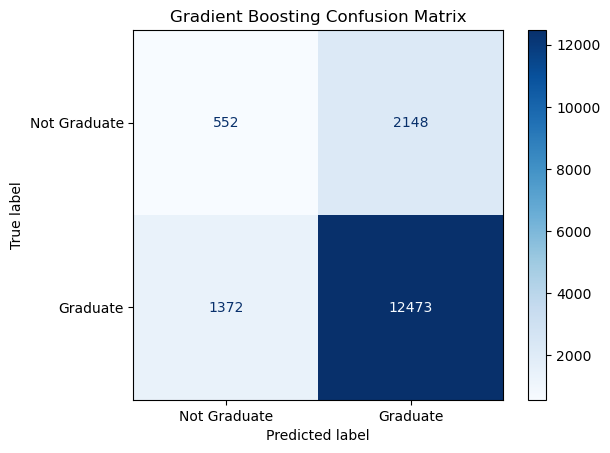

Results for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.29      0.20      0.24      2700
           1       0.85      0.90      0.88     13845

    accuracy                           0.79     16545
   macro avg       0.57      0.55      0.56     16545
weighted avg       0.76      0.79      0.77     16545

AUC Score: 0.601




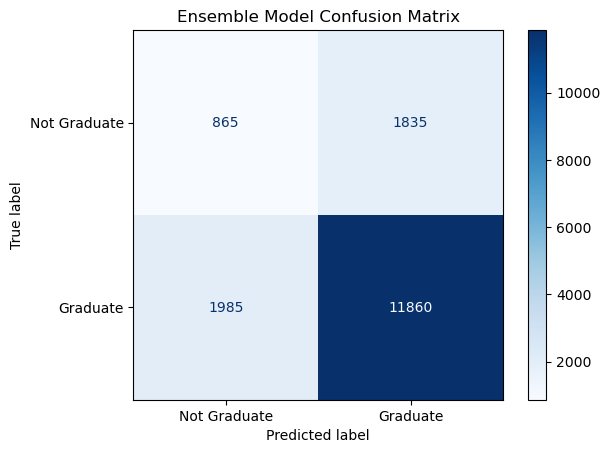

Ensemble Model Results:
              precision    recall  f1-score   support

           0       0.30      0.32      0.31      2700
           1       0.87      0.86      0.86     13845

    accuracy                           0.77     16545
   macro avg       0.58      0.59      0.59     16545
weighted avg       0.77      0.77      0.77     16545

Ensemble AUC Score: 0.644

Summary of AUC Scores:
                 Model  AUC Score
0  Logistic Regression   0.653139
1        Random Forest   0.646500
2              XGBoost   0.629412
3    Gradient Boosting   0.600718
4             Ensemble   0.643643


In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
# Define SMOTE and Random Under-Sampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
'''
sampling_strategy=1.0: Balance the classes perfectly (equal number of samples in each class).
sampling_strategy=0.5: After applying SMOTE, the minority class will have half as many samples as the majority class.
'''
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
'''
sampling_strategy=0.8: Keep 80% of the majority class, removing 20%.
sampling_strategy=0.5: Make the majority class twice the size of the minority class.

'''

# Resampling pipeline
balance_pipeline = ImbPipeline([('smote', smote), ('under', under)])
'''
By combining SMOTE and random under-sampling, 
we can first increase the minority class with SMOTE, 
then reduce the majority class with under-sampling. 
This provides a balanced approach where both classes end up closer in size.
'''
X_train_bal, y_train_bal = balance_pipeline.fit_resample(X_train, y_train)



from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Define models and hyperparameter grids
models = {
    "Logistic Regression": GridSearchCV(
        LogisticRegression(class_weight='balanced', max_iter=1000),
        param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
        cv=5, scoring='roc_auc'
    ),
    "Random Forest": GridSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42),
        param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10]},
        cv=5, scoring='roc_auc'
    ),
    "XGBoost": GridSearchCV(
        XGBClassifier(scale_pos_weight=len(y_train_bal[y_train_bal==0]) / len(y_train_bal[y_train_bal==1])),
        param_grid={'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]},
        cv=5, scoring='roc_auc'
    ),
    "Gradient Boosting": GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.2]},
        cv=5, scoring='roc_auc'
    )
}


# Dictionary to store results
results = {}

# Train each model and collect performance metrics
for model_name, grid_search in models.items():
    # Fit model with resampled training data
    grid_search.fit(X_train_bal, y_train_bal)
    best_model = grid_search.best_estimator_
    
    # Predictions and probabilities
    y_pred = best_model.predict(X_test)
    y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Graduate", "Graduate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    # Classification report and AUC score
    report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_probs)
    results[model_name] = {"Classification Report": report, "AUC Score": auc_score}
    
    print(f"Results for {model_name}:")
    print(report)
    print(f"AUC Score: {auc_score:.3f}")
    print("\n" + "=" * 50 + "\n")

# Ensemble Model - Soft Voting Classifier
# Use the best models from each individual GridSearchCV result for the ensemble
ensemble_model = VotingClassifier(
    estimators=[(name, grid_search.best_estimator_) for name, grid_search in models.items()],
    voting='soft'
)

# Fit the ensemble model
ensemble_model.fit(X_train_bal, y_train_bal)
y_ensemble_pred = ensemble_model.predict(X_test)
y_ensemble_pred_probs = ensemble_model.predict_proba(X_test)[:, 1]

# Ensemble performance metrics
ensemble_report = classification_report(y_test, y_ensemble_pred)
ensemble_auc_score = roc_auc_score(y_test, y_ensemble_pred_probs)

# Display ensemble confusion matrix
cm = confusion_matrix(y_test, y_ensemble_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Graduate", "Graduate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ensemble Model Confusion Matrix")
plt.show()

# Display ensemble results
print("Ensemble Model Results:")
print(ensemble_report)
print(f"Ensemble AUC Score: {ensemble_auc_score:.3f}")

# Summary Table of AUC Scores
summary_df = pd.DataFrame({
    "Model": list(results.keys()) + ["Ensemble"],
    "AUC Score": [results[model_name]["AUC Score"] for model_name in results.keys()] + [ensemble_auc_score]
})

print("\nSummary of AUC Scores:")
print(summary_df)

Playing around with sampling techniques doesn't seem to greatly improve performance statistics so we move on to try more complex modeling techniques


## Neural Network

For the following models, we use 5 predictors as we were testing to see if these 5 predictors (which can be used to represent most students) can be used to create a decent model. 
- Later we do compare how a reduced model is compared to a full model with all predictors

2024-12-06 06:05:58.744563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 06:05:58.744653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 06:05:58.746304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 06:05:58.752564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 06:05:59.689242: W tensorflow/compiler/tf2

Epoch 1/30


2024-12-06 06:06:00.340469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-12-06 06:06:03.077486: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7187418110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-06 06:06:03.077543: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2024-12-06 06:06:03.082565: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-06 06:06:03.104905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1733465163.188735  262979 device_compiler.h:186] Compiled cl

966/966 [==============================] - 6s 3ms/step - loss: 0.5830 - accuracy: 0.6460 - val_loss: 0.6618 - val_accuracy: 0.6647
Epoch 2/30
966/966 [==============================] - 2s 3ms/step - loss: 0.5346 - accuracy: 0.6918 - val_loss: 0.6376 - val_accuracy: 0.7149
Epoch 3/30
966/966 [==============================] - 2s 3ms/step - loss: 0.5179 - accuracy: 0.7178 - val_loss: 0.6193 - val_accuracy: 0.7222
Epoch 4/30
966/966 [==============================] - 3s 3ms/step - loss: 0.5081 - accuracy: 0.7298 - val_loss: 0.6145 - val_accuracy: 0.7199
Epoch 5/30
966/966 [==============================] - 3s 3ms/step - loss: 0.5026 - accuracy: 0.7282 - val_loss: 0.6110 - val_accuracy: 0.6927
Epoch 6/30
966/966 [==============================] - 3s 3ms/step - loss: 0.4997 - accuracy: 0.7371 - val_loss: 0.6094 - val_accuracy: 0.7162
Epoch 7/30
966/966 [==============================] - 3s 4ms/step - loss: 0.4981 - accuracy: 0.7282 - val_loss: 0.5967 - val_accuracy: 0.7329
Epoch 8/30
966/96

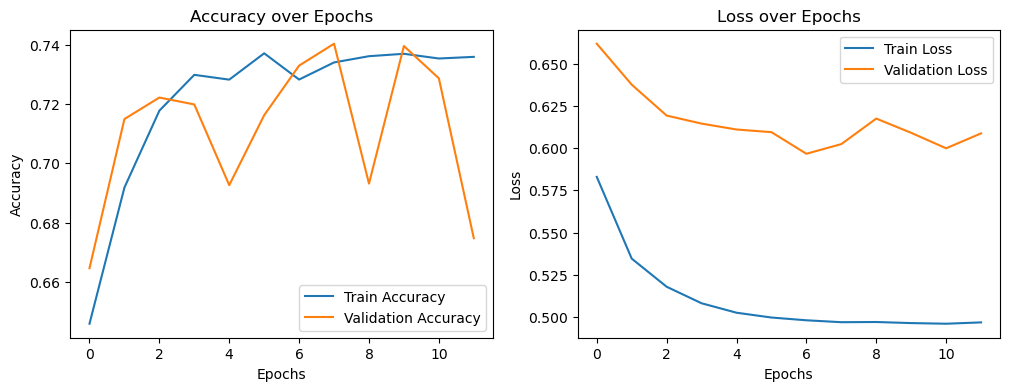

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Prepare the Data
key_columns_modeling_revised = [
    'Race_Asian', 
    'Race_White',
    'TOTAL HS LANG YEARS TAKEN', 
    'HS ZIP Income Level Encoded', 
    'APPLIED URM'
]

X = data[key_columns_modeling_revised]
y = data['DEGREE ACHIEVED']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Step 4: Build the Neural Network Model
# Add L2 regularization to Dense layers
from tensorflow.keras.regularizers import l2
model = Sequential([
    # Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    # BatchNormalization(),
    # Dropout(0.3),

    # Dense(32, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),
    
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),


    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 5: Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 6: Train the Model

# Use early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate class weights to balance the two classes
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict = {0: 2.0, 1: 0.5}  # Adjusted weights (higher importance for 0)

history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2, 
    class_weight=class_weight_dict, 
    callbacks = [early_stopping],
    verbose=1
)

# Step 7: Evaluate the Model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.6).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Plot training history
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)


- Model seems to be underfitting

Epoch 1/30
966/966 [==============================] - 7s 5ms/step - loss: 0.8032 - accuracy: 0.6623 - val_loss: 0.8632 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/30
966/966 [==============================] - 5s 5ms/step - loss: 0.6761 - accuracy: 0.7095 - val_loss: 0.7187 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 3/30
966/966 [==============================] - 5s 5ms/step - loss: 0.5858 - accuracy: 0.7252 - val_loss: 0.6549 - val_accuracy: 0.7446 - lr: 0.0010
Epoch 4/30
966/966 [==============================] - 5s 5ms/step - loss: 0.5349 - accuracy: 0.7387 - val_loss: 0.6199 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 5/30
966/966 [==============================] - 5s 5ms/step - loss: 0.5155 - accuracy: 0.7391 - val_loss: 0.6198 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 6/30
966/966 [==============================] - 5s 5ms/step - loss: 0.5087 - accuracy: 0.7415 - val_loss: 0.6345 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 7/30
966/966 [==============================] - 5s 5ms/step - lo

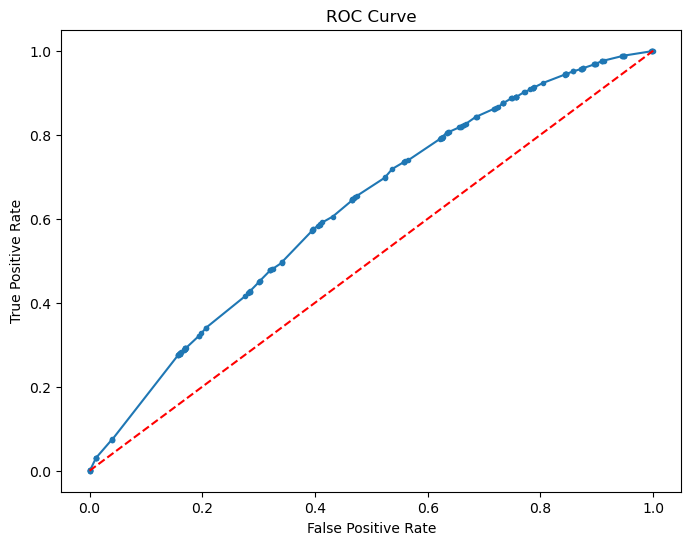

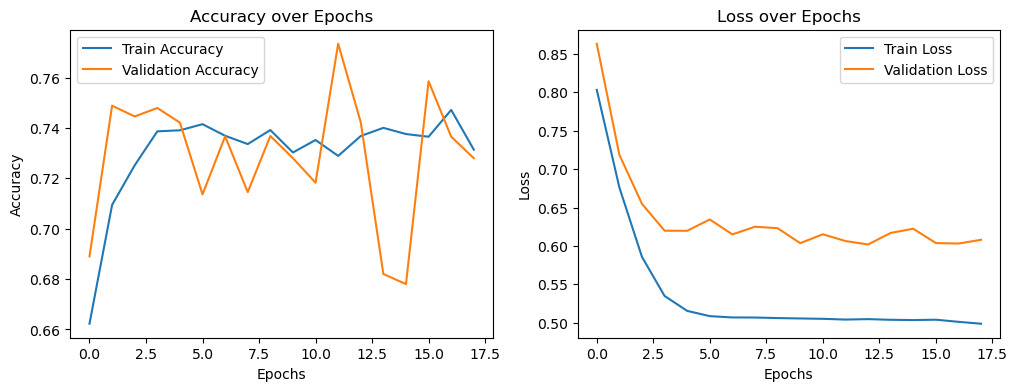

In [41]:
'''
Changes:
- dynamic thresholding using ROC curve
    - ROC (Receiver Operating Characteristic) curve helps identify the optimal 
    threshold where the difference between the True Positive Rate (TPR) and False
    Positive Rate (FPR) is maximized. This ensures better handling of class imbalance.
- Learning rate scheduling
    - If the learning rate is too high, the model might oscillate around the optimal weights.
    - If it’s too low, the model can get stuck or converge too slowly.
    - By reducing the learning rate dynamically during training
    (for example, after 10 epochs), the model fine-tunes itself in later stages and 
    reduces overfitting.
- Narrower neural layers
    - Deeper networks (more layers) allow the model to learn more complex 
    relationships within the data. However, just adding width (more neurons) 
    can lead to overfitting since the model becomes overly complex.
    - Narrower layers (fewer neurons) force the model to learn compact 
    representations of the input data, which improves generalization.

'''

key_columns_modeling_revised = [
    'Race_Asian', 
    'Race_White',
    'TOTAL HS LANG YEARS TAKEN', 
    'HS ZIP Income Level Encoded', 
    'APPLIED URM'
]

X = data[key_columns_modeling_revised]
y = data['DEGREE ACHIEVED']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid') 
])


from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)  # Lower learning rate

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Learning rate scheduler to reduce learning rate if the model plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Use early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate class weights to balance the two classes
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: 2.0, 1: 0.5}  # Adjusted weights (higher importance for 0)


history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2, 
    class_weight=class_weight_dict, 
    # callbacks = [early_stopping],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


y_pred_probs = model.predict(X_test)
# y_pred = (y_pred_probs > 0.6).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Apply the optimal threshold to predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc_curve(fpr, tpr)

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)


Epoch 1/30
966/966 [==============================] - 7s 5ms/step - loss: 1.0433 - accuracy: 0.3907 - val_loss: 1.0880 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 2/30
966/966 [==============================] - 5s 5ms/step - loss: 0.9278 - accuracy: 0.3392 - val_loss: 1.0123 - val_accuracy: 0.4256 - lr: 0.0010
Epoch 3/30
966/966 [==============================] - 5s 5ms/step - loss: 0.8383 - accuracy: 0.3282 - val_loss: 0.9473 - val_accuracy: 0.3738 - lr: 0.0010
Epoch 4/30
966/966 [==============================] - 5s 5ms/step - loss: 0.7744 - accuracy: 0.3065 - val_loss: 0.9034 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 5/30
966/966 [==============================] - 5s 5ms/step - loss: 0.7371 - accuracy: 0.2758 - val_loss: 0.8728 - val_accuracy: 0.2252 - lr: 0.0010
Epoch 6/30
966/966 [==============================] - 5s 5ms/step - loss: 0.7190 - accuracy: 0.2969 - val_loss: 0.8622 - val_accuracy: 0.2121 - lr: 0.0010
Epoch 7/30
966/966 [==============================] - 5s 5ms/step - lo

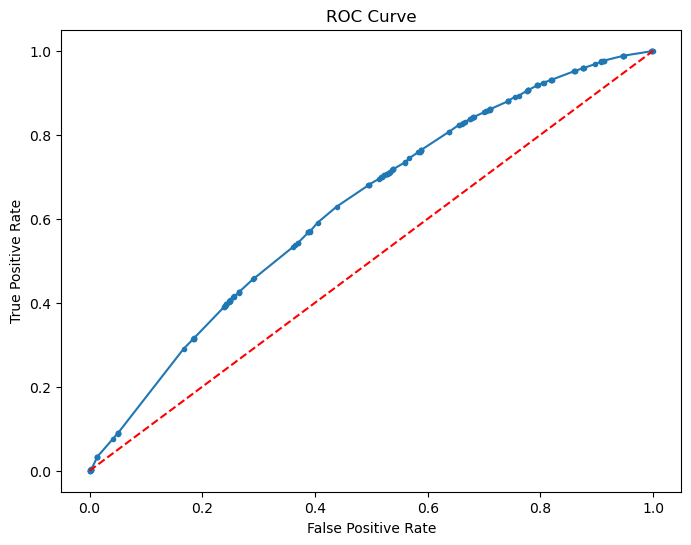

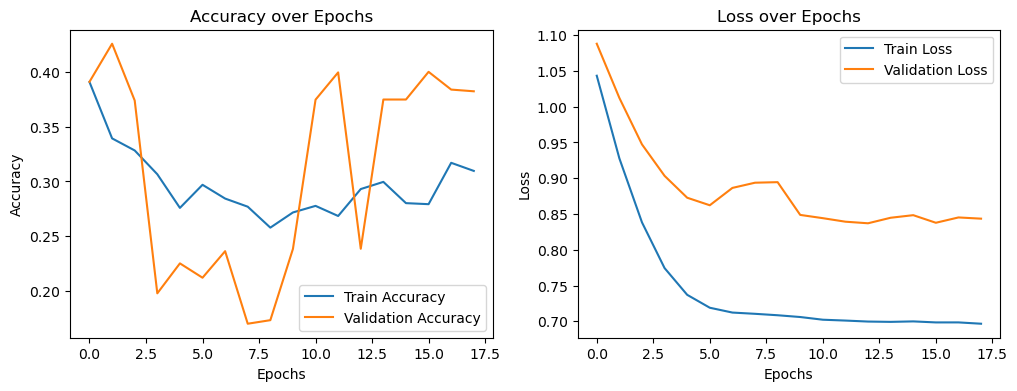

In [42]:
'''
Changes:
- dynamic thresholding using ROC curve
    - ROC (Receiver Operating Characteristic) curve helps identify the optimal 
    threshold where the difference between the True Positive Rate (TPR) and False
    Positive Rate (FPR) is maximized. This ensures better handling of class imbalance.
- Learning rate scheduling
    - If the learning rate is too high, the model might oscillate around the optimal weights.
    - If it’s too low, the model can get stuck or converge too slowly.
    - By reducing the learning rate dynamically during training
    (for example, after 10 epochs), the model fine-tunes itself in later stages and 
    reduces overfitting.
- Narrower neural layers
    - Deeper networks (more layers) allow the model to learn more complex 
    relationships within the data. However, just adding width (more neurons) 
    can lead to overfitting since the model becomes overly complex.
    - Narrower layers (fewer neurons) force the model to learn compact 
    representations of the input data, which improves generalization.

'''

key_columns_modeling_revised = [
    'Race_Asian', 
    'Race_White',
    'TOTAL HS LANG YEARS TAKEN', 
    'HS ZIP Income Level Encoded', 
    'APPLIED URM'
]

X = data[key_columns_modeling_revised]
y = data['DEGREE ACHIEVED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid') 
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)  # Lower learning rate

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: 4.0, 1: 0.5}  # Adjusted weights (higher importance for 0)


history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2, 
    class_weight=class_weight_dict, 
    # callbacks = [early_stopping],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


y_pred_probs = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

y_pred = (y_pred_probs >= optimal_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc_curve(fpr, tpr)

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)


In conclusion, NN model do seem to perform better but don't show a significant increase in performance, especially when looking at the AUC scores of these models.
- Therefore, we decided to go back to using traditional models instead since the interpretability of NN models is too complex and out of our scope.

## Final Stages

We first try to deal with anomaly observations and outliers using models designed for this.

### Isolation Forest and Local Outlier Factor

In [45]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

key_columns = [
    # Demographic
    'APPLIED FIRST GENERATION',
    'Race_Asian', 
    'Race_White',
    'Race_African American or Black', 
    'Race_American-Indian', 
    'Race_Hispanic or Latino',
    'Race_NHPI', 
    'APPLIED URM',

    'Gender_F',
    'Gender_M', 

    # Academic Performance
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',

    # Socioeconomic Indicators
    'HS ZIP Income Level Encoded', 
    'ADDR ZIP Income Level Encoded',
    'APPLIED FEE WAIVER ALL',
    'FAFSA'
]
# Define features for anomaly detection
anomaly_features = [
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',
]

# Use Isolation Forest to identify anomalies with a 5% contamination rate
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['Anomaly_Score'] = iso_forest.fit_predict(data[anomaly_features])

# Filter out the anomalies
data_cleaned = data[data['Anomaly_Score'] == 1].drop(columns=['Anomaly_Score'])
print(f"Data shape after removing anomalies: {data_cleaned.shape}")


Data shape after removing anomalies: (52389, 298)


#### Train test data from IsoForest

In [46]:
# Define the target and features after removing anomalies
X_clean = data_cleaned[key_columns]
y_clean = data_cleaned['DEGREE ACHIEVED']
# Train-test split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)


In [47]:

from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

anomaly_features = [
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',
]

# Instantiate and apply LOF for anomaly detection
lof = LocalOutlierFactor(n_neighbors=20, metric='minkowski', p=2, novelty=True)
lof.fit(data[anomaly_features])  # Train LOF model on anomaly features
'''
- LOF identifies outliers based on local density, which can better capture anomalies 
in high-dimensional data with varying densities.
- LOF does not require a fixed contamination rate, so it’s more flexible in identifying 
genuine outliers based on data distribution.
'''

# Predict anomalies
data['Anomaly_Score'] = lof.predict(data[anomaly_features])

# Filter to retain only normal instances (LOF labels normal points as 1, outliers as -1)
data_cleaned_LOF = data[data['Anomaly_Score'] == 1].drop(columns=['Anomaly_Score'])
print(f"Data shape after removing LOF-detected anomalies: {data_cleaned_LOF.shape}")



Data shape after removing LOF-detected anomalies: (50254, 298)


#### Train test data from LOF

In [48]:

# Define the target and features after removing anomalies
X_LOF = data_cleaned_LOF[key_columns]
y_LOF = data_cleaned_LOF['DEGREE ACHIEVED']
X_train_LOF, X_test_LOF, y_train_LOF, y_test_LOF = train_test_split(X_LOF, y_LOF, test_size=0.2, random_state=42, stratify=y_LOF)


#### Modeling using the cleaned datasets above

What we did was we cleaned the dataset in 2 different ways and trained models on each cleaned data set.
- After doing so, we test these models on different datasets:
1. original model on original data
2. iso forest model on iso forest cleaned data
3. lof model on lof cleaned data

and so on.

We do this to see how cleaning the data affects the performance of models and to see if cleaned models on cleaned data perform better. 

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight_orig:.2f}")

# Perform Grid Search with Stratified Cross-Validation
# Instantiate the cost-sensitive XGBoost model with calculated scale_pos_weight
xgb_cost_sensitive = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_grid_search_orig = GridSearchCV(
    xgb_cost_sensitive, 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='roc_auc'
)
xgb_grid_search_orig.fit(X_train, y_train)

# Output best parameters and best AUC score from cross-validation
print(f"Best parameters for cost-sensitive XGBoost: {xgb_grid_search_orig.best_params_}")
print(f"Best AUC score for cost-sensitive XGBoost: {xgb_grid_search_orig.best_score_:.3f}")


Calculated scale_pos_weight: 0.20
Best parameters for cost-sensitive XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best AUC score for cost-sensitive XGBoost: 0.655


In [56]:
scale_pos_weight_clean = len(y_train_clean[y_train_clean == 0]) / len(y_train_clean[y_train_clean == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight_clean:.2f}")
# Perform Grid Search with Stratified Cross-Validation

# Instantiate the cost-sensitive XGBoost model with calculated scale_pos_weight
xgb_cost_sensitive = XGBClassifier(
    scale_pos_weight=scale_pos_weight_clean,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_grid_search_clean = GridSearchCV(
    xgb_cost_sensitive, 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='roc_auc'
)
xgb_grid_search_clean.fit(X_train_clean, y_train_clean)

# Output best parameters and best AUC score from cross-validation
print(f"Best parameters for cost-sensitive XGBoost: {xgb_grid_search_clean.best_params_}")
print(f"Best AUC score for cost-sensitive XGBoost: {xgb_grid_search_clean.best_score_:.3f}")


Calculated scale_pos_weight: 0.19
Best parameters for cost-sensitive XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best AUC score for cost-sensitive XGBoost: 0.653


In [57]:
scale_pos_weight_LOF = len(y_train_LOF[y_train_LOF == 0]) / len(y_train_LOF[y_train_LOF == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight_LOF:.2f}")
# Perform Grid Search with Stratified Cross-Validation

xgb_cost_sensitive = XGBClassifier(
    scale_pos_weight=scale_pos_weight_LOF,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_grid_search_LOF = GridSearchCV(
    xgb_cost_sensitive, 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='roc_auc'
)
xgb_grid_search_LOF.fit(X_train_LOF, y_train_LOF)

# Output best parameters and best AUC score from cross-validation
print(f"Best parameters for cost-sensitive XGBoost: {xgb_grid_search_LOF.best_params_}")
print(f"Best AUC score for cost-sensitive XGBoost: {xgb_grid_search_LOF.best_score_:.3f}")


Calculated scale_pos_weight: 0.19
Best parameters for cost-sensitive XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best AUC score for cost-sensitive XGBoost: 0.661


#### Performance on Test Data

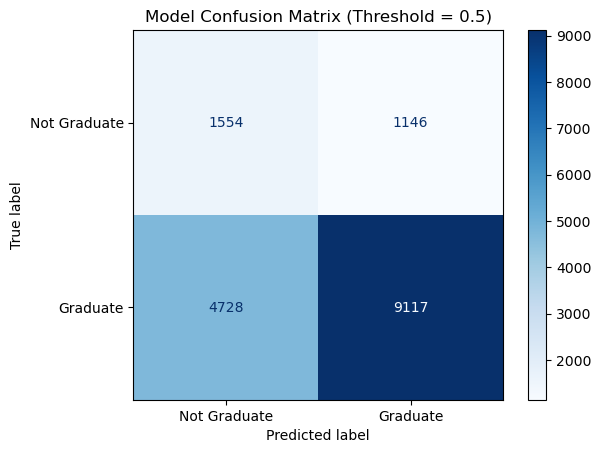

Classification Report with Threshold = 0.5:
               precision    recall  f1-score   support

           0       0.25      0.58      0.35      2700
           1       0.89      0.66      0.76     13845

    accuracy                           0.64     16545
   macro avg       0.57      0.62      0.55     16545
weighted avg       0.78      0.64      0.69     16545

AUC Score with Threshold = 0.5: 0.659


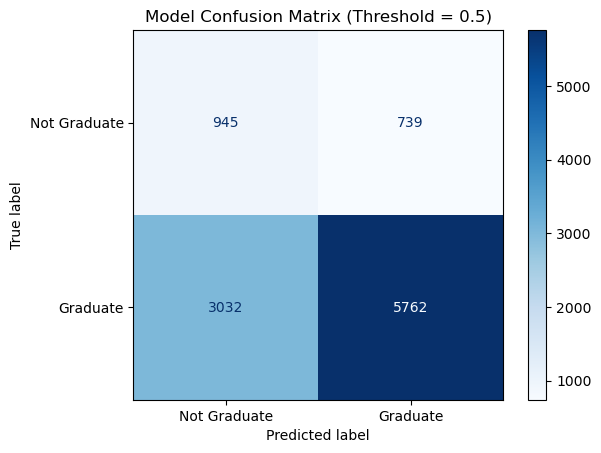

Classification Report with Threshold = 0.5:
               precision    recall  f1-score   support

           0       0.24      0.56      0.33      1684
           1       0.89      0.66      0.75      8794

    accuracy                           0.64     10478
   macro avg       0.56      0.61      0.54     10478
weighted avg       0.78      0.64      0.69     10478

AUC Score with Threshold = 0.5: 0.651


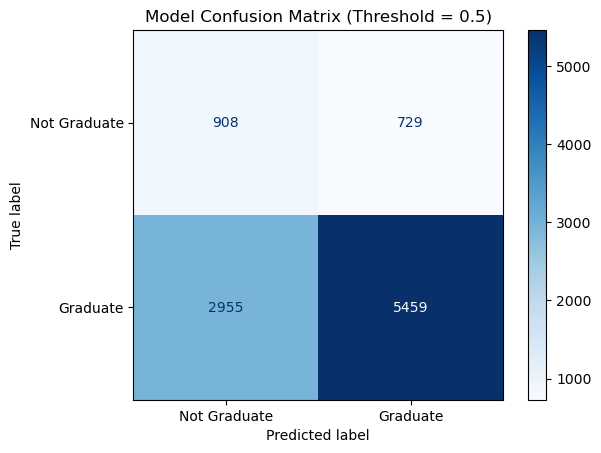

Classification Report with Threshold = 0.5:
               precision    recall  f1-score   support

           0       0.24      0.55      0.33      1637
           1       0.88      0.65      0.75      8414

    accuracy                           0.63     10051
   macro avg       0.56      0.60      0.54     10051
weighted avg       0.78      0.63      0.68     10051

AUC Score with Threshold = 0.5: 0.640


In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

def evaluate_with_custom_threshold(model, X_test, y_test, threshold):
    y_pred_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # Confusion matrix and report
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Graduate", "Graduate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Model Confusion Matrix (Threshold = {threshold})")
    plt.show()

    # Classification report and AUC
    report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_probs)
    print(f"Classification Report with Threshold = {threshold}:\n", report)
    print(f"AUC Score with Threshold = {threshold}: {auc_score:.3f}")
# Test custom thresholds
# evaluate_with_custom_threshold(xgb_grid_search_orig, X_test, y_test, threshold=0.3)
evaluate_with_custom_threshold(xgb_grid_search_orig, X_test, y_test, threshold=0.5)
# evaluate_with_custom_threshold(xgb_grid_search_clean, X_test_clean, y_test_clean, threshold=0.3)
evaluate_with_custom_threshold(xgb_grid_search_clean, X_test_clean, y_test_clean, threshold=0.5)
# evaluate_with_custom_threshold(xgb_grid_search_LOF, X_test_LOF, y_test_LOF, threshold=0.3)
evaluate_with_custom_threshold(xgb_grid_search_LOF, X_test_LOF, y_test_LOF, threshold=0.5)


After going through combinations of testing the models, we see that these outlier detection methods do not significantly improve performacne and since there is little documentation on them, our ability to utilize them effectively is limited.

Therefore, we turn to a manual selection of observations that we believe can be outliers. 

### Manual Selection of Outliers

Before we get started on the final modeling part of the project keep in mind the following:
- We decided to include more variables from the dataset to see if the model can gather more information from these variables and potentially improve performance
- We thought about criteria that "anomaly" observations would fit for instance, students that had over a certain amount of college credits but did not end up graduating.
    - Instances like these were removed from the dataset manually. 

In [59]:
# New variables
variables = [
    'APPLIED ATHLETE', # 0 or 1
    'PRIMARY LANGUAGE CD',
    'APPLIED VETERAN', # 0 or 1
    'PARENT 1 EDU LVL',
    'PARENT 2 EDU LVL',
    'AGE'
]
# Null values & encoding
data['PRIMARY LANGUAGE CD'] = data['PRIMARY LANGUAGE CD'].fillna('Unknown')
# New column: if the primary langauge is English then 1, else 0
data['PRIMARY LANGUAGE ENGLISH'] = data['PRIMARY LANGUAGE CD'].apply(lambda x: 1 if x == 'E' else 0)
data['AGE'] = data['AGE'].fillna(data['AGE'].median())

# Deal with PARENT EDU LVL
data['PARENT 1 EDU LVL'] = data['PARENT 1 EDU LVL'].replace("No Answer", None)
data['PARENT 2 EDU LVL'] = data['PARENT 2 EDU LVL'].replace("No Answer", None)

below_bachelors = [
    "Has No High School Diploma",
    "Has High School Diploma",
    "Attended College, No Degree",
    "Associates Degree"
]
common_below_bachelors = data[data['PARENT 1 EDU LVL'].isin(below_bachelors)]['PARENT 1 EDU LVL'].mode()[0]

data.loc[
    (data['APPLIED FIRST GENERATION'] == 1) &
    (data['PARENT 1 EDU LVL'].isnull()),
    'PARENT 1 EDU LVL'
] = common_below_bachelors

data.loc[
    (data['APPLIED FIRST GENERATION'] == 1) &
    (data['PARENT 2 EDU LVL'].isnull()),
    'PARENT 2 EDU LVL'
] = common_below_bachelors

data.loc[
    (data['APPLIED FIRST GENERATION'] == 0) &
    (data['PARENT 1 EDU LVL'].isnull()),
    'PARENT 1 EDU LVL'
] = "Bachelors Degree"

data.loc[
    (data['APPLIED FIRST GENERATION'] == 0) &
    (data['PARENT 2 EDU LVL'].isnull()),
    'PARENT 2 EDU LVL'
] = "Bachelors Degree"

# Econding for PARENT LVL
education_mapping = {
    "Has No High School Diploma": 0,
    "Has High School Diploma": 1,
    "Attended College, No Degree": 2,
    "Associates Degree": 3,
    "Bachelors Degree": 4,
    "Masters Degree": 5,
    "Professional Degree": 6,
    "Doctorate Degree": 7
}

data['PARENT 1 EDU LVL ENCODED'] = data['PARENT 1 EDU LVL'].map(education_mapping)
data['PARENT 2 EDU LVL ENCODED'] = data['PARENT 2 EDU LVL'].map(education_mapping)

key_columns = [
    'APPLIED FIRST GENERATION',
    'Race_Asian', 
    'Race_White',
    'Race_African American or Black', 
    'Race_American-Indian', 
    'Race_Hispanic or Latino',
    'Race_NHPI', 
    'APPLIED URM',
 
    'Gender_F',
    'Gender_M',
 
    'TOTAL HS LANG YEARS TAKEN', 
    'HS GPA', 
    'HS AP UNITS',
 
    'HS ZIP Income Level Encoded', 
    'ADDR ZIP Income Level Encoded',
    'APPLIED FEE WAIVER ALL',
    'FAFSA',
 
    'APPLIED ATHLETE',
    'PRIMARY LANGUAGE ENGLISH',
    'APPLIED VETERAN',
    'PARENT 1 EDU LVL ENCODED',
    'PARENT 2 EDU LVL ENCODED',
    'AGE'
]

print(data[key_columns].isna().sum())
print(f"Data shape: {data.shape}")

APPLIED FIRST GENERATION          0
Race_Asian                        0
Race_White                        0
Race_African American or Black    0
Race_American-Indian              0
Race_Hispanic or Latino           0
Race_NHPI                         0
APPLIED URM                       0
Gender_F                          0
Gender_M                          0
TOTAL HS LANG YEARS TAKEN         0
HS GPA                            0
HS AP UNITS                       0
HS ZIP Income Level Encoded       0
ADDR ZIP Income Level Encoded     0
APPLIED FEE WAIVER ALL            0
FAFSA                             0
APPLIED ATHLETE                   0
PRIMARY LANGUAGE ENGLISH          0
APPLIED VETERAN                   0
PARENT 1 EDU LVL ENCODED          0
PARENT 2 EDU LVL ENCODED          0
AGE                               0
dtype: int64
Data shape: (55147, 299)


In [60]:
# Define the target and features after removing anomalies
X = data[key_columns]
y = data['DEGREE ACHIEVED']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
scale_pos_weight_orig = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight_orig:.2f}")
# Perform Grid Search with Stratified Cross-Validation
# Instantiate the cost-sensitive XGBoost model with calculated scale_pos_weight
xgb_cost_sensitive = XGBClassifier(
    scale_pos_weight=scale_pos_weight_orig,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define the parameter grid
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

xgb_grid_search_orig = GridSearchCV(
    xgb_cost_sensitive, 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='roc_auc'
)
xgb_grid_search_orig.fit(X_train, y_train)

# Output best parameters and best AUC score from cross-validation
print(f"Best parameters for cost-sensitive XGBoost: {xgb_grid_search_orig.best_params_}")
print(f"Best AUC score for cost-sensitive XGBoost: {xgb_grid_search_orig.best_score_:.3f}")

Calculated scale_pos_weight: 0.20
Best parameters for cost-sensitive XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best AUC score for cost-sensitive XGBoost: 0.673


#### Filtering Manually

In [62]:
condition_non_graduates = (
    (data['GPA EARNED HOURS'] >= 120) &
    (data['GPA HOURS'] >= 60) &
    (data['LAST TERM UIUC INSTITUTIONAL GPA'] > 3.4) &
    (data['DEGREE ACHIEVED'] == 0)
)

condition_high_school_non_graduation = (
    (data['TOTAL HS LANG YEARS TAKEN'] >= 4) &
    (data['HS GPA'] > 3.4) &
    (data['DEGREE ACHIEVED'] == 0)
)

condition_graduates = (
    (data['LAST TERM UIUC INSTITUTIONAL GPA'] < 2.5) &
    (data['DEGREE ACHIEVED'] == 1)
)

condition_high_school_graduation = (
    (data['TOTAL HS LANG YEARS TAKEN'] <= 1) &
    (data['HS GPA'] < 2.5) &
    (data['DEGREE ACHIEVED'] == 1)
)

rows_to_remove_v2 = data[
    condition_non_graduates |
    condition_graduates |
    condition_high_school_graduation |
    condition_high_school_non_graduation
]
len(rows_to_remove_v2)

4337

In [63]:
data_cleaned2 = data.drop(rows_to_remove_v2.index).reset_index(drop=True)
X_cleaned2 = data_cleaned2[key_columns]
y_cleaned2 = data_cleaned2['DEGREE ACHIEVED']
X_train_new2, X_test_new2, y_train_new2, y_test_new2 = train_test_split(X_cleaned2, y_cleaned2, test_size=0.2, random_state=42, stratify=y_cleaned2)

In [64]:
scale_pos_weight_new2 = len(y_train_new2[y_train_new2 == 0]) / len(y_train_new2[y_train_new2 == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight_new2:.2f}")

xgb_cost_sensitive = XGBClassifier(
    scale_pos_weight=scale_pos_weight_new2,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_grid_search_new2 = GridSearchCV(
    xgb_cost_sensitive, 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='roc_auc'
)
xgb_grid_search_new2.fit(X_train_new2, y_train_new2)

# Output best parameters and best AUC score from cross-validation
print(f"Best parameters for cost-sensitive XGBoost: {xgb_grid_search_new2.best_params_}")
print(f"Best AUC score for cost-sensitive XGBoost: {xgb_grid_search_new2.best_score_:.3f}")

Calculated scale_pos_weight: 0.14
Best parameters for cost-sensitive XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best AUC score for cost-sensitive XGBoost: 0.816


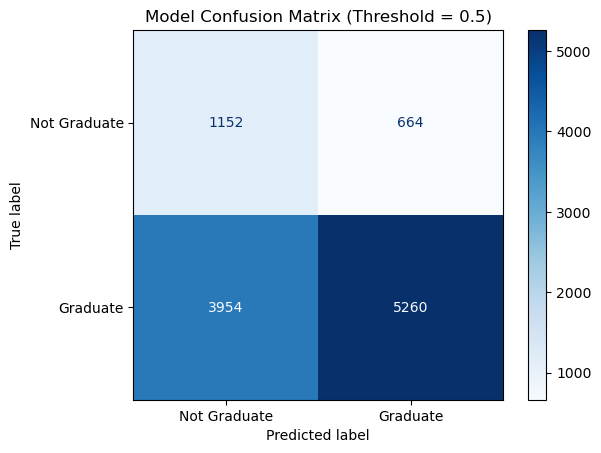

Classification Report with Threshold = 0.5:
               precision    recall  f1-score   support

           0       0.23      0.63      0.33      1816
           1       0.89      0.57      0.69      9214

    accuracy                           0.58     11030
   macro avg       0.56      0.60      0.51     11030
weighted avg       0.78      0.58      0.64     11030

AUC Score with Threshold = 0.5: 0.653


In [65]:
# Trained on the cleaned dataset and tested on the original dataset
evaluate_with_custom_threshold(xgb_grid_search_new2, X_test, y_test, threshold=0.5)

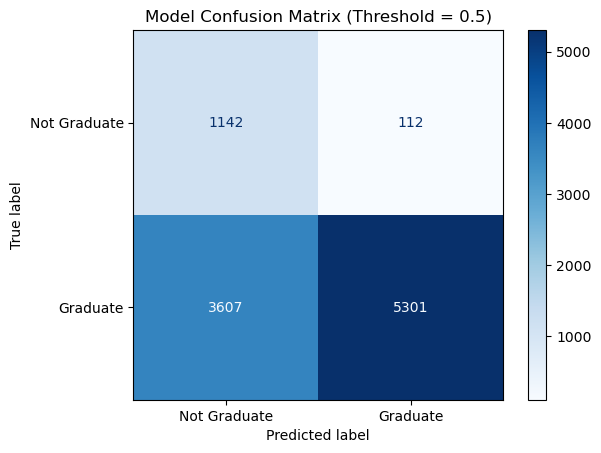

Classification Report with Threshold = 0.5:
               precision    recall  f1-score   support

           0       0.24      0.91      0.38      1254
           1       0.98      0.60      0.74      8908

    accuracy                           0.63     10162
   macro avg       0.61      0.75      0.56     10162
weighted avg       0.89      0.63      0.70     10162

AUC Score with Threshold = 0.5: 0.826


In [66]:
# Trained on the cleaned dataset and tested on the cleaned dataset
evaluate_with_custom_threshold(xgb_grid_search_new2, X_test_new2, y_test_new2, threshold=0.5)

# Final Results

The final model used was an XGBoost model that was cleaned of outliers manually using criteria mentioned in the code. 

A streamlit interface was made using this code in the app.py file in the repository